### Libraries and settings

In [38]:
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget
# Importation librairies nécessaires
import pandas as pd
import os
import numpy as np
import pylab as pl
import re
import matplotlib.pyplot as plt
import pandas_bokeh
from pandas_bokeh import plot_bokeh
pandas_bokeh.output_notebook()
import json
from unidecode import unidecode
import warnings
warnings.filterwarnings('ignore')
from dtypes import dtypes_beltweets_orig


Loading BokehJS ...

In [39]:
# Paramètres cosmétiques
# Taille des graphiques
plt.rcParams["figure.figsize"] = [20, 8]
# Taille de l'affichage des données pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


In [40]:
# Fonction pour afficher un tweet type "embedding" dans le notebook 
from IPython.core.display import display, HTML
def display_tweet(status_id) :
    display(HTML('<blockquote class="twitter-tweet"><a href="https://twitter.com/x/status/'+str(status_id)+'"></a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>'))

# Data wrangling and cleaning
We merge several datasets and clean data before further analysis, and exportation of subsets for toping modelling. 
It is possible to skip this step by importing `data=pd.read_csv('data/beltweets_full.csv')` and move on to to [Data exploration](#data-explo).

### Dataset importation and merging
Data were collected over several months in multiple batches. To keep track of tweet count for each batch, it is organized as follows :  

```
data  
│   beltweets_nlp_w_und.csv  
│   detected_lang_tweets.csv  
│   timeline_events_short.xlsx  
│
├───BelTweets_Master  
│       BelTweets_Last_20200820.csv  
│       BelTweets_Last_20200825.csv  
│       ... .csv  
│       BelTweets_Last_20201229.csv  
│  
├───newdata  
│   ├───new_data_1  
│   │       0805_0812.csv  
│   │       0812_0816.csv  
│   │       0816_0820.csv  
│   │       0825_0831.csv  
│   │  
│   ├───new_data_2  
│   │       0820-0920.csv  
│   │       0920_1030.csv  
│   │       1030_1130.csv  
│   │       1130_1231.csv  
│   │  
│   └───new_hashtags  
│           hashtags1_top100.csv  
│           hashtags2_cyrillic.csv  
│           hashtags3_trending_after.csv  
│           hashtags4_trending_short.csv  
│  
└───newdata2  
    ├───new_data_3  
    │       0601_0808.csv  
    │  
    └───new_hashtags  
            hashtags1_top100.csv  
            hashtags2_cyrillic.csv  
            hashtags3_trending_after.csv  
            hashtags5_trending_before.csv
```

Original dataset

In [41]:

# Fields we will not use :
dropcols=['display_text_width',
    'urls_url', # Normalement c'est la liste des URLS mentionnées, tronqué par rtweet. urls_expanded_url contient la 1ère (?) de ces URLS
    'urls_t.co', 
    'geo_coords', # Vide dans Rtweets, on conserve "coords_coords"
    'favorite_count', # Même chose que les 'likes', existe en double dans rtweet
    'profile_banner_url', 
    'profile_background_url',
    'media_expanded_url', # C'est le lien vers l'image dans le status, on peut le reconstruire si besoin. Dans la v2 pas d'expanded_url.
    'media_t.co',
    # Ext_media : Dans la v1, renvoie une liste si plusieurs medias (4 photos max)
    # On conserve ext_media_url
    'ext_media_expanded_url', 
    'ext_media_t.co',
    'profile_url', # N'existe pas V2
    'profile_expanded_url',
    'account_lang', # Vide
    'reply_to_screen_name', # Beaucoup de données manquantes, TODO les ré-imputer depuis le JSON ?
    'profile_image_url', # Inutile
    'media_url', # Redondant avec ext_media_url
    # most retweet fields are useless since they inherit everything from the original tweet
    # First two carry info pertaining to the retweeting user
    # 'retweet_location', 
    # 'retweet_description',
    'retweet_verified',
    'retweet_text',
    'retweet_source',
    'retweet_retweet_count',
    'retweet_favorite_count']

In [42]:
# Importing original dataset Mobilise/BelTweets
data = pd.DataFrame()
data = pd.concat([pd.read_csv(f, usecols = lambda x: x not in dropcols, dtype=dtypes_beltweets_orig) for f in os.scandir('data/BelTweets_Master') if '2020' in f.name and 'new' not in f.name], ignore_index=True)\
    .drop_duplicates(subset='status_id', keep="last") # Suppression duplicates (keep last pour avoir les tweets les plus "à jour")
# Deal with inconsistencies in ID columns
idcols=[c for c in data.columns if '_id' in c]
for c in idcols :
    data[c]=data[c].astype(str).replace(['nan', '<NA>'], np.nan) # ID columns are mixed, pass IDs as string
    data[c]=data[c].str.replace('x', '') # IDs start with an x in the original dataset, remove it
    if 'mentions' not in c:
        data[c]=data[c].astype('Int64')


# Rename ``media type`` column
data.drop('ext_media_type', axis=1, inplace=True)
data.rename(columns={'media_type':'ext_media_type'}, inplace=True) 
# Parse relevant fields as lists
data[[ 'urls_expanded_url','ext_media_type','ext_media_url']]=data[[ 'urls_expanded_url','ext_media_type','ext_media_url']]\
    .applymap(lambda x: x.split(' ') if isinstance(x, str) else np.nan)
data['_meta'] = 'original_dataset'

New data

In [43]:
# Import fields to keep and/or rename, to match output from RTweet
from rtweet_conversion import torename, extra_cols
# Select fields to import
cols = list(torename.keys())+extra_cols
# Remove fields we will not use
[cols.remove(k) for k,v in torename.items() if v in dropcols]
# Add useful fields that were introduced in V2 
cols.extend(['context_annotations','entities.annotations', 'geo.id'])
data_folders=[d.name for d in os.scandir('data/newdata')]
new_dtypes= {torename[list(torename.keys())[list(torename.values()).index(k)]]:v for k,v in dtypes_beltweets_orig.items() if k in torename.values()}
newframes1=[]
newframes2=[]
for d in data_folders :
    # newdata=pd.DataFrame()
    newfiles = [f for f in os.scandir('data/newdata/'+d)]
    print('merging files in : '+d)
    if newfiles :
        for f in newfiles :
            # newdata= pd.read_csv(f, usecols=[c for c in cols if c!='media'], dtype=new_dtypes, converters = {c:str for c in idcols})
            newdata= pd.read_csv(f, usecols=[c for c in cols if c!='media'], dtype=new_dtypes)
            if d=='new_hashtags' :
                newdata['_meta']=f.name
            else :
                newdata['_meta']=d
            # Rename available columns according to V1/rtweet format
            newdata.rename(columns=torename, inplace=True)

            # Evaluate lists
            newdata[['urls_expanded_url',
            'ext_media_type',
            'ext_media_url']] = newdata[[ 'urls_expanded_url',
            'ext_media_type',
            'ext_media_url'
            ]].applymap(lambda x: eval(x) if isinstance(x, str) and '["' in x else x.split(' ') if isinstance(x, str) else np.nan)
            
            newdata[['context_annotations',
            'entities.annotations']] = newdata[['context_annotations',
            'entities.annotations'
            ]].applymap(lambda x: json.loads(x) if isinstance(x, str) else np.nan)                        
                    

            cols1=[c for c in newdata.columns if c not in ['context_annotations', 'entities.annotations','geo.id']]
            newframes1.append(newdata[cols1])
            # Save separate dataframes with data that exists only in V2
            newframes2.append(newdata[['status_id', 'context_annotations', 'entities.annotations', 'geo.id']])
            # Merge with original data
print ('merging all datasets...')
data=pd.concat([data]+newframes1, copy=False, ignore_index=True)
# Remove duplicates
# Keep original data when possible in case users changed description or other info
data=data.drop_duplicates(subset='status_id', keep="first")
# We want to add the V2 data
data=data.join(pd.concat(newframes2, copy=False, ignore_index=True).drop_duplicates(subset='status_id', keep='last').set_index('status_id'), on='status_id')
print('after merge, data contains : '+ str(len(data)) + ' tweets')



merging files in : aug20_dec31_v2
merging files in : before_election
merging files in : missing_days
merging files in : new_hashtags
merging all datasets...
after merge, data contains : 4321824 tweets


In [46]:
# At the end of the merge, Create Timestamps from date variables
data['created_at']=pd.to_datetime(data['created_at'], utc=True)
data['account_created_at']=pd.to_datetime(data['account_created_at'], utc=True)
data['retweet_created_at']=pd.to_datetime(data['retweet_created_at'], utc=True)

In [47]:
# Unescape some HTML escaped chars in text, like &amp
from html import unescape
print ('len before', len(data['text']))
data['text']=data['text'].apply(lambda x: unescape(x))
data['text']=data['text'].str.replace(r'\\n', ' ', regex=True)
data['text']=data['text'].str.replace("\n\r","")
data['text']=data['text'].str.replace("\r","")
print ('len after', len(data['text']))

len before 4321824
len after 4321824


In [48]:
# Remove variables
del newdata
del newfiles
del newframes1
del newframes2

## Missing data, feature engineering

Add tweet count

In [49]:
# Add the user's tweet count within the dataset (different from the overall account's `statuses_count`)
data['n_tweets']=data[['user_id', 'status_id']].groupby('user_id')['user_id'].transform('size')

In [50]:
# Add the user's retweet to tweet ratio
data["RT_to_tweets"]=data[['user_id', 'status_id', 'is_retweet']].sort_values('is_retweet', ascending=False).groupby(['user_id', 'is_retweet'])['is_retweet'].transform('size')/data['n_tweets']

Extract missing hashtags

In [51]:
# Hashtags are sometimes undetected from the tweet's text (in V1 systematically, in V2 often)
n=np.random.randint(0, 1999)
sample=data[['text', 'hashtags']][data['hashtags'].isna()].sample(n=1, random_state=n)

print(sample)

# Function based on regex to extract them
def extract_hashtags(text) :
    # h = re.findall(r'#\S+', text) # Extract including "#" character
    h = re.findall(r'#(\w+)', text)
    h.extend(re.findall(r'# (\w+)', text))
    if ' '.join(h) == '' :
        return np.nan
    else :
        return ' '.join(h).lower()
# Example
extract_hashtags(sample['text'].iloc[0])
# extract_hashtags('sample # belarus #test')

# Same function but returns a list, or nan if empty
def list_hashtags(text) :
    if isinstance(text, str) :
        # h = re.findall(r'#\S+', text) # Extract including "#" character
        h = re.findall(r'#(\w+)', text, flags=re.IGNORECASE)
        h.extend(re.findall(r'# (\w+)', text))
        if not bool(h) :
            return np.nan
        else :
            return [u.lower() for u in h]
    else :
        return np.nan


                                                                                                                                                                                                          text  \
5868140  18+. На видео убийство демонстранта Александра Тарайковского на Пушкинской улице в Минске. Оно снято со стороны кинотеатра «Аврора». Запись только сейчас передали @euroradio https://t.co/TZydz1Smdk   

        hashtags  
5868140      NaN  


In [52]:
# Extract hashtags from user descriptions 
# (We use them later to remove irrelevant tweets)
data['descr_hashtags']=data['description'].apply(lambda x: list_hashtags(x))

In [53]:
# # # Apply to all dataset
print('Hashtags total : '+str(len(data['hashtags'])))
print('hashtags missing : '+str(len(data['hashtags'][data['hashtags'].isna()]))+ '\n extracting hashtags from text...')
print('Setting lowercase on existing hashtags')
data['hashtags']=data['hashtags'].str.lower()
# # # Replacing with newfound hashtags
# data['hashtags'] = data.apply(lambda x: extract_hashtags(x['text']) if x['_meta']=='original_dataset' else x['hashtags'], axis=1)
# print('hashtags missing after : '+str(len(data['hashtags'][data['hashtags'].isna()]))+ ', applying to rest of dataset...')
# Apply to all dataset since the result seems better, save the result in a column
data['hashtags_nw'] = data['text'].apply(lambda x: extract_hashtags(x))
# Take a combination of original and extracted hashtags, deleting duplicates with list(dict.fromkeys(list))
print('found hashtags for '+str(len(data['hashtags_nw'][data['hashtags_nw'].isna()])) + 'tweets. Merging newfound and existing hashtags....')
# Combine TODO Do we need them in a list or a single string ? For now
data['hashtags']=data['hashtags'].str.cat(data['hashtags_nw'], sep=' ', na_rep='').apply(lambda x : np.nan if (isinstance(x, float) or x==' ') else list(dict.fromkeys([c for c in x.split(' ') if c!=''])))
print('tweets with hashtags missing after : '+str(len(data['hashtags'][data['hashtags'].isna()])))
data.drop('hashtags_nw', axis=1, inplace=True)

Hashtags total : 4321824
hashtags missing : 1249974
 extracting hashtags from text...
Setting lowercase on existing hashtags
found hashtags for 414091tweets. Merging newfound and existing hashtags....
tweets with hashtags missing after : 414058


## Data cleaning, round 1

Removing duplicates if remaining

In [54]:
# Removing true duplicates, return number of "unique" tweets
print(len(data))
# print(len(newdata.newdata.drop_duplicates(subset=['status_id'], keep='first')))
data=data.drop_duplicates(subset=['status_id'], keep='last', ignore_index=True)
len(data)

4321824


4321824

In [55]:
# Nb of unique user IDS
len(data.user_id.drop_duplicates(keep='first'))

872890

Deleting a few Outliers
* duplicates on status_id, but with different tweet text. 
* Account error messages.
  * -> ~500 tweets

In [56]:
# Pour la plupart ils correspondent à des messages automatiques de violation de la politique de Twitter, on pourra les supprimer aussi
print(len(data))
data=data.drop(data.loc[data['text'].str.contains('account is temporarily unavailable')].index)
print(len(data))

4321824
4321665


### Deleting tweets from bots
* We exclude tweets from users whose ``name`` contains the word 'bot' or 'b0t' ; or where other text fields (`screen name`, `description`, `source`) normalized to latin contain the word 'bot' 
  * -> 1.5k users, 30k tweets 
* We tried to train a classifier on the ``mean_freq`` (time delta between tweets), ``F2F`` (ratio between friends and followers) (Derhab et al, 0.1109/ACCESS.2021.3074953). 
* We tried to confirm these using the tool "Botometer" ("Detection of Novel Social Bots by Ensembles of Specialized Classifiers.", Sayyadiharikandeh et al. [(DOI)](https://doi.org/10.1145/3340531.3412698)) but we ran out of time.

In [57]:
# Relevant columns
botcols=['text', 'created_at', 'is_retweet', 'n_tweets', 'RT_to_tweets', 'mean_freq', 'F2F', 'name', 'screen_name', 'description', 'quoted_description', 'retweet_description', 'hashtags', 'source', 'lang', 'status_id', 'user_id']

In [58]:
# Just fill a column with NA so as to not break the notebook 
data['mean_freq']=None
# Computing mean freq (VERY LONG) 
# data=data.join((data[['status_id', 'user_id', 'created_at']].sort_values('user_id').groupby(['user_id'])
#     .created_at
#     .agg(Mean_Freq=lambda group: group.sort_values().diff().mean()))['Mean_Freq'].rename('mean_freq'),
#     on='user_id')

In [ ]:
# # Computing F2F
data['F2F'] = data['friends_count']/data['followers_count']

In [60]:
from unidecode import unidecode
bot_mask = (

    data['name'].str.cat(data[['screen_name', 'description', 'retweet_description', 'source']], sep=' ', na_rep='').str.contains(
        r'(?<![a-z])b[o0]t(?![a-z])', flags=re.IGNORECASE
        ) |
    data['name'].str.contains(r'[BБ][oо0][tт](?![a-zа-я])')
        |
    data['name'].str.cat(data[['screen_name', 'description', 'retweet_description', 'source']], sep=' ', na_rep='').apply(lambda x: unidecode(x)).str.contains(
        r'(?<![a-z])[bB][o0][t](?![a-z])', flags=re.IGNORECASE
        )
)

In [61]:
len(data[botcols][bot_mask])

29204

In [63]:
len(data[bot_mask])

29204

In [64]:
print('Removing messages from bots. Before : ' + str(len(data)) + ' tweets')
data=data[~bot_mask]
print('After : ' + str(len(data)) + ' tweets')

Removing messages from bots. Before : 4321665 tweets
After : 4292461 tweets


### Removing spam and noise
* exclude hashtags pertaining to the hongkong protests (~150 000 tweets, 95 % retweets) (see [Hashtag section](#remove_hashtags))
  * -> ~100 000 tweets contain these hashtags
  * -> more based on user descriptions and keywords ('hk')
* exclude tweets containing other places ? ('hk')
* exclude spam and accounts that have posted it (crypto, marketing...)
  * -> delete based on keywords ?
  * -> delete based ML

Removing hashtags and keywords

In [65]:
exclude_hashtags=[ 'fridaysforfreedom',
'навальный',  'covid19', 'coronavirus'
'femxarxa',
'коронавирус',
# Hongkong, Thailand and "Milk Tea Alliance" hashtags
'bewater',
'hkerswithyou'
'hongkongers',
'hongkong',
'standwithhongkong',
'save12hkyouths',
'milkteaalliance'
'freehongkong',
'hk2belarus',
'standwithhk',
'standwiththailand',
'เสาหลักจะหักเผด็จการ',
'hk',
'hong kong',
'hong-kong',
# Other countries/Places; Other trending protests or news 
'trumpsamerica',
'azerbaijan',
'beirut',
'uyghurs',
'ultimahora',
'venezuela',
'standwithuyghurs',
'somoscontinuidad',
'крымукраина',
'navalny',
'путинубийца',
'caracas',
'maracaibo',
'tel-aviv',
'sanfrancisco',
# Spam, marketing, brands
'мнепятнадцать',
'юмор',
'cryptocurrency',
'crypto',
'contest',
'bitcoin',
'ETH',
'blockchain',
'BTC',
'FIAT',
'virtualtravel',
'travelblogger',
'iphone',
'microsoft',
'soccer',
'championsleague',
'luxury',
'design',
'thepartsshow',
'etsy'
]
exclude_kw=[
'hong',
'kong',
'bewater',
'hkerswithyou',
'hongkongers',
'hongkonger',
'hongkong',
'standwithhongkong',
'save12hkyouths',
'milkteaalliance'
'freehongkong',
'hk2belarus',
'standwithhk',
'standwiththailand',
'เสาหลักจะหักเผด็จการ',
'somoscontinuidad',
'thepartsshow',
'casino',
'etsy',
'ringtone']

In [66]:
# At each stage of data removal we create a mask (boolean series indexed like our data, where 1 = tweet to remove)
# We plot the cumulated size of masks, so as to know how many new tweets we'll be removing at each stage
# Tweets w unwanted hashtags
mask1 = data['hashtags'].explode().isin(exclude_hashtags).sort_values()[lambda x: ~x.index.duplicated(keep='last')]
plot1 = data[['status_id','hashtags']][mask1].explode('hashtags')\
    ['hashtags'][lambda x: x.isin(exclude_hashtags)]\
    .value_counts().sort_values()
    #  .size().unstack().sum().sort_values() BUG this should work like below ?
# Tweets w unwanted hashtags in user descr
mask2 = data['descr_hashtags'].explode().isin(exclude_hashtags).sort_values()[lambda x: ~x.index.duplicated(keep='last')]
plot2 = data[['status_id','descr_hashtags']][(~mask1)][mask2].explode('descr_hashtags')\
    [lambda x: x['descr_hashtags'].isin(exclude_hashtags)]\
    .groupby(['status_id', 'descr_hashtags'])\
    .size().unstack().sum().sort_values()
# Tw. w unwanted keywords in user descr
# drop3 = data['description'][~(mask1|mask2)].str.findall(r''+('|'.join(exclude_kw)), flags=re.IGNORECASE)
drop3 = data['description'][~(mask1|mask2)].str.findall(r''+('|'.join(['(?<![a-z])'+kw+'(?![a-z])' for kw in exclude_kw])), flags=re.IGNORECASE)
mask3 = drop3.fillna(0).astype(bool)
plot3 = pd.concat([data['status_id'], drop3.rename('descr_kw')], axis=1)[ ~(mask1| mask2) ][mask3]\
    .explode('descr_kw')
plot3['descr_kw']=plot3['descr_kw'].str.lower()
plot3=plot3.groupby(['status_id', 'descr_kw'])\
    .size().unstack().sum().sort_values()
# Tw. w unwanted keywords in text fields
# Do not parse retweets (for performance reasons)
drop4=data['text'][~data.is_retweet].str.lower().str.findall(r''+('|'.join(['(?<![a-z])'+kw+'(?![a-z])' for kw in exclude_kw])), flags=re.IGNORECASE)
mask4 = drop4.fillna(0).astype(bool)
# Add tweets that are retweets of masked tweets to the mask
# This is much faster than parsing all tweets but we remove less
mask4 = (
    data[['status_id', 'retweet_status_id']].isin(data[~data.is_retweet]['status_id'][mask4]).any(axis=1)
)
plot4 = pd.concat([data['status_id'], drop4.rename('text_kw')], axis=1)[ ~(mask1| mask2 | mask3) ][mask4]\
    .explode('text_kw')\
    .groupby(['status_id', 'text_kw'])\
    .size().unstack().sum().sort_values()
# # Alternative : parse every tweet, including retweets, for those keywords
# drop4 = data['text'].str.findall(r''+('|'.join(exclude_kw)), flags=re.IGNORECASE)
# sum(drop4.fillna(0).astype(bool))

In [67]:
at_pat = r'@(\w+)'
h_pat= r'#(\w+)'
not_text_pat=r'(\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*)|(@(\w+))|(#(\w+))'

# def prct_tokens_not_text(series) :
#     return(series.str.count(not_text_pat, flags=re.IGNORECASE)/series.str.count(r'(\w+)', flags=re.IGNORECASE)) # cette formule ne splitte pas correctement
def prct_tokens_not_text(series) :
    return((series.str.count(not_text_pat, flags=re.IGNORECASE)/(series.str.split().apply(lambda x: len([w for w in x if len(w)>0])))).apply(lambda x: 1 if x>1 else x))

In [68]:
data.loc[~data.is_retweet, 'prct_tokens_not_text']=data.loc[~data.is_retweet]['text'].pipe(prct_tokens_not_text)

In [69]:
data['text'][mask4|mask1|mask2|mask3].pipe(prct_tokens_not_text).describe()

count    231014.000000
mean          0.299092
std           0.268041
min           0.000000
25%           0.121951
50%           0.200000
75%           0.366667
max           1.000000
Name: text, dtype: float64

In [70]:
import seaborn as sns
sns.set(rc={'figure.figsize':(6,4)})

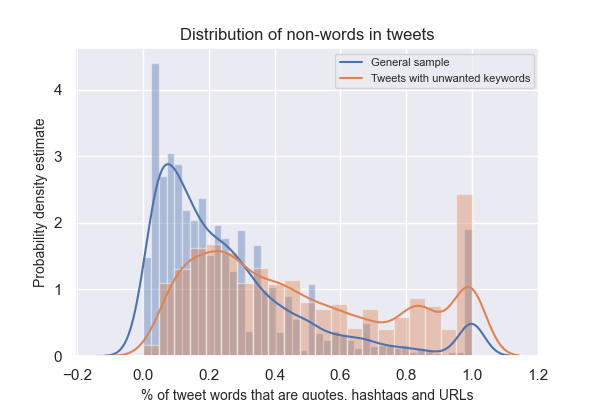

In [71]:
# Visualizing distribution of non-words in tweets we delete
y=data[~(data.is_retweet | data.is_quote |data.reply_to_status_id.notna())]['text'][mask4|mask1|mask2|mask3].sample(10000).pipe(prct_tokens_not_text)
x= data[~(data.is_retweet | data.is_quote |data.reply_to_status_id.notna())]['text'].sample(len(y)).pipe(prct_tokens_not_text)
fig=sns.distplot(x)
fig=sns.distplot(y)
fig.set_ylabel('Probability density estimate', fontsize=10)
fig.set_xlabel('% of tweet words that are quotes, hashtags and URLs', fontsize=10)
fig.set(title='Distribution of non-words in tweets')
plt.legend(loc='upper right', labels=['General sample', 'Tweets with unwanted keywords'], fontsize=8);

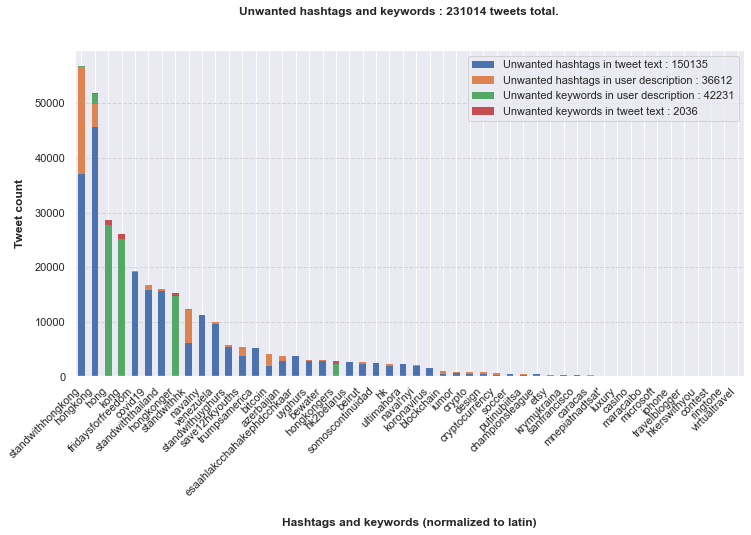

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
from unidecode import unidecode
fig, ax = plt.subplots(figsize=(12,6))
toplot=pd.concat([p.rename(x+str(sum(m))) for (p,x,m) in [
    (plot1, 'Unwanted hashtags in tweet text : ', mask1),
    (plot2, 'Unwanted hashtags in user description : ', mask2[~mask1]),
    (plot3, 'Unwanted keywords in user description : ', mask3[~(mask1| mask2)]),
    (plot4, 'Unwanted keywords in tweet text : ', mask4[ ~(mask1|mask2 |mask3) ])
    ]], axis=1)
toplot.index=[unidecode(x) for x in toplot.index.values]
# toplot.sort_values(lambda x: x.sum(axis=1), ascending=False)
toplot=toplot.assign(sum=toplot.sum(axis=1)).sort_values('sum', ascending=False).iloc[:, :-1]
# toplot.sort_values([toplot.columns[i] for i in [0, 3]], ascending=False).plot.bar(ax=ax, width=0.5, stacked=True)
toplot.plot.bar(ax=ax, width=0.5, stacked=True, edgecolor="none")

fig.suptitle('Unwanted hashtags and keywords : %d tweets total.' % (sum(mask1|mask2|mask3|mask4)), weight='bold', size=12)
# Set grid
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# Rotate x-ticks
plt.xticks(rotation=45, horizontalalignment='right')
# Set count label for each bar
# plt.bar_label(ax.containers[0], color='grey')
# plt.bar_label(ax.containers[3], color='grey')
# Set x-axis label
ax.set_xlabel("Hashtags and keywords (normalized to latin)", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Tweet count", labelpad=10, weight='bold', size=12);
# Void variable
# todrop=None
plt.show()

In [73]:
print ('Tweet count : %d, dropping unwanted tweets...' %len(data))
data=data[~(mask1|mask2|mask3|mask4)]
print ('Tweet count : %d' %len(data))

Tweet count : 4292461, dropping unwanted tweets...
Tweet count : 4061447


## Infer undetermined languages

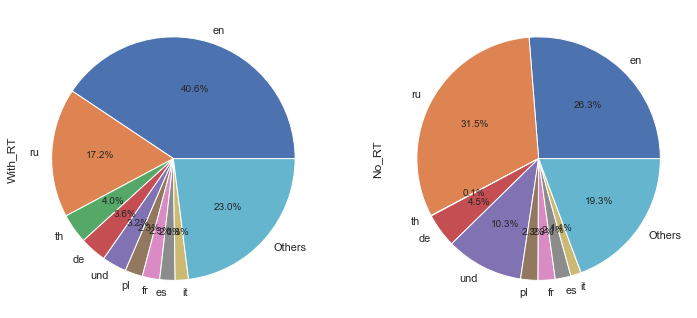

In [74]:
# Plot languages, piechart
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
# With retweets
toplot=pd.merge(data.lang.value_counts(normalize=True).rename('With_RT'), (data[['is_retweet', 'lang']][~data.is_retweet].lang.value_counts(normalize=True).rename('No_RT')), left_index=True, right_index=True)
toplot.loc['Others'] = toplot[toplot<0.06].sum()
toplot=toplot[~(toplot['With_RT']<=0.02)]
toplot.plot.pie(ax=ax, subplots=True, legend=None, autopct='%1.1f%%');
fig.set_facecolor('white');

* left include RT, right is without retweets
* 4% tweets undetected language ('und') : keepers
* Belarusian (ISO code='be') either undetected or mixed with 'ru'

We will infer 'undetected' language when the author of the tweet only tweets in one single other language w/ 3:1 ratio between their main lang and 'undetermined' tweets, and a zscore > 0 for this lang

In [75]:
# Make a table of user's tweets count in each language
# Compute z-score three ways : for the language, for the user, and for the entire table
# Trim data to only "en", "ru" and "und" 
from scipy.stats import zscore
lang=data[['status_id', 'lang', 'user_id', 'country_code']].groupby(['user_id', 'lang']).size().unstack()\
    [lambda x: x['und'].notna()]
lang=lang.dropna(axis=1, how='all')
# For now, only check users whose tweets are "und" language and 1 single other lang
lang=lang[lang.fillna(False).astype(bool).sum(axis=1)==2]
# We can also
# lang=lang.drop(lang.dropna(subset=[c for c in lang if c!='und'], thresh=3).index, axis=0)
zcols=pd.concat([
    # Overall z score
    (pd.Series(np.nanmax(zscore(lang.to_numpy(), axis=None, nan_policy='omit'), axis=1)).rename('zscore_overall')).reset_index(drop=True),
    (pd.Series(lang.columns[np.nanargmax(zscore(lang.to_numpy(), axis=None, nan_policy='omit'), axis=1)]).rename('lang_overall')).reset_index(drop=True),
    # column-wise (this user's number of tweets in ``lang`` relative to the rest of user's tweet count in ``lang``)
    (pd.Series(np.nanmax(zscore(lang, axis=0, nan_policy='omit'), axis=1)).rename('zscore_axis0')).reset_index(drop=True),
    (pd.Series( lang.columns[np.nanargmax(zscore(lang, axis=0, nan_policy='omit'), axis=1)] ).rename('lang_axis0')).reset_index(drop=True),
    # row-wise (this user's tweet count in each ``lang`` compared to their tweet count in other ``lang``)
    (pd.Series(np.nanmax(zscore(lang, axis=1, nan_policy='omit'), axis=1)).rename('zscore_axis1')).reset_index(drop=True),
        # For the row-wise top lang, we have to compute differently
    pd.DataFrame(zscore(lang, axis=1, nan_policy='omit')).rename(columns=dict((i,j) for i,j in (enumerate(lang.columns)))).idxmax(axis=1).fillna('und').rename("lang_axis1").reset_index(drop=True),
    # the simple ratio between their most tweeted language and their tweets with undetermined lang
    (pd.Series(lang[[c for c in lang.columns if c!='und']].max(axis=1)/lang['und']).rename('max_ratio')).reset_index(drop=True),
    (pd.Series(lang[lang.columns].idxmax(axis=1)).rename('max_lang')).reset_index(drop=True)
], axis=1)

# For now we infer language for users with a 3:1 ratio between their main lang and 'und' tweets, AND a zscore > 0 for this lang
zlang = lang.join(zcols.set_index(lang.index))
cols=['und', 'en', 'ru']
cols.extend(zlang.columns[-8:])
to_complete=zlang[cols].sort_values('max_ratio', ascending=False)[(zlang['zscore_axis0']>=00) & (zlang['max_ratio']>=3)] 
to_complete

,und,en,ru,zscore_overall,lang_overall,zscore_axis0,lang_axis0,zscore_axis1,lang_axis1,max_ratio,max_lang
user_id,,,,,,,,,,,
2239021813,1.0,NaN,NaN,50.002381,pl,20.466184,pl,1.0,pl,705.0,pl
926352090607349760,2.0,NaN,1365.0,97.110655,ru,58.078038,ru,1.0,ru,682.5,ru
1573512366,2.0,722.0,NaN,51.215776,en,43.009303,en,1.0,en,361.0,en
40309296,1.0,334.0,NaN,23.521821,en,19.640698,en,1.0,en,334.0,en
1061257553177403392,1.0,NaN,NaN,23.164940,pl,9.452374,pl,1.0,pl,329.0,pl
...,...,...,...,...,...,...,...,...,...,...,...
961000843,2.0,NaN,6.0,0.110436,ru,0.095910,und,1.0,ru,3.0,ru
499696436,2.0,6.0,NaN,0.110436,en,0.095910,und,1.0,en,3.0,en
2574444817,3.0,9.0,NaN,0.324565,en,0.340523,und,1.0,en,3.0,en


In [76]:
# Map the newly detected lang to all the user's tweets
# Store it in a temp column
data=data.join(to_complete['max_lang'].rename('lang'), on='user_id', rsuffix='_n')
# TODO Separate retweets here ? From code above retweet_lang would be consistent w/lang
# data['lang', 'user_id', 'retweet_user_id', ][data.is_retweet & (data['lang']=='und') & (data['lang_n'])]
# Count the tweets where we would replace "undetected" with the new lang
print('Language will be added to '+str(len(data[data['lang']=='und'].lang_n.dropna())) +' tweets, '
    +str(len(data[(data['lang_n']=='ru')& (data['lang']=='und')].lang_n.dropna())) + ' for russian, '
    +str(len(data[(data['lang_n']=='en')& (data['lang']=='und')].lang_n.dropna())) + ' for english'
    )

Language will be added to 9119 tweets, 2908 for russian, 5251 for english


In [88]:
# Check tweets
tweet=data[['status_id', 'lang_n']][data['lang_n']=='en'].sample()['status_id'].iloc[0]
display_tweet(tweet)

Infer using Spacy Langdetect

In [78]:
# import spacy
# from spacy.language import Language
# from spacy_langdetect import LanguageDetector
# def get_lang_detector(nlp, name):
#     return LanguageDetector()
# Language.factory("language_detector", func=get_lang_detector)
# nlp_en=spacy.load('en_core_web_lg')
# nlp_ru=spacy.load('ru_core_news_lg')
# # nlp_en.add_pipe('language_detector', last=True)
# # nlp_en.add_pipe(LanguageDetector(), name="language_detector", last=True)
# nlp_en.add_pipe("language_detector", last=True)

In [89]:
newlangs=pd.read_csv('data/detected_lang_tweets.csv')
# newlangs['status_id']=newlangs['status_id'].astype(str)

In [80]:
len(newlangs)

97154

In [90]:
newlangs.loc[newlangs.detected_lang.notna(), 'detected_lang']=newlangs[newlangs.detected_lang.notna()]['detected_lang'].str.replace(r'dict_values\(', '').str.replace(r'\)', '').apply(lambda x: eval(x))

In [82]:
# newlangs['lang']=newlangs['detected_lang'].apply(lambda x: x[0])
# newlangs['score']=newlangs['detected_lang'].apply(lambda x: x[1])

In [91]:
if "lang_spacy" in data.columns :
    data.drop(['lang_spacy', 'lang_spacy_score'], axis=1, inplace=True)
data=data.join(newlangs.set_index('status_id')['detected_lang'].rename('lang'), on='status_id', rsuffix='_spacy')
# data['lang', 'user_id', 'retweet_user_id', ][data.is_retweet & (data['lang']=='und') & (data['lang_n'])]
# Count the tweets where we would replace "undetected" with the new lang
# data['lang_spacy']=pd.NA
data['lang_spacy_score']=data["lang_spacy"].map(lambda x: x[1], na_action='ignore')
data['lang_spacy']=data['lang_spacy'].map(lambda x: x[0], na_action='ignore')
data['lang_spacy']=data['lang_spacy'].str.replace('UNKNOWN', 'und')
del newlangs

In [92]:
print('Language will be added to '+str(len(data[data['lang']=='und'].lang_spacy.dropna())) +' tweets, '
    +str(len(data[(data['lang_spacy']=='ru')& (data['lang']=='und')].lang_spacy.dropna())) + ' for russian, '
    +str(len(data[(data['lang_spacy']=='en')& (data['lang']=='und')].lang_spacy.dropna())) + ' for english'
    )

Language will be added to 97154 tweets, 23211 for russian, 19863 for english


Comparison of methods

In [93]:
# Column that we want to keep for comparing methods
nlpcols=['text',
 'created_at',
 'lang',
 # add this to compare inferred language
 'lang_n', 
 'lang_spacy',
 'lang_spacy_score',
 'lang_user_n',
 'lang_user_zscore',
 # /add this to compare inferred language
 'n_tweets',
 'retweet_count',
 'RT_to_tweets',
 'mean_freq',
 'name',
 'screen_name',
 'description',
 'hashtags',
 'status_id',
 'user_id',
 '_meta']

In [94]:
# Import the best overall zscored language from the user's history
data=data.join(zlang['lang_overall'].rename('lang'), on='user_id', rsuffix='_user_n')
# Also import the zscore itself
data=data.join(zlang['zscore_overall'].rename('lang'), on='user_id', rsuffix='_user_zscore')
# The lang detected with overall zscore is 100% consistent with the lang-specific zscore we used originally
(data[['lang_user_n', 'lang_n']].dropna().lang_user_n!=data[['lang_user_n', 'lang_n']].dropna().lang_n).value_counts()

False    133616
dtype: int64

In [95]:
url_pat=r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*'

at_pat = r'@(\w+)'
h_pat= r'#(\w+)'
not_text_pat=r'(\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*)|(@(\w+))|(#(\w+))'

def prct_tokens_not_text(series) :
    return(series.str.count(not_text_pat, flags=re.IGNORECASE)/(series.str.split().apply(lambda x: len([w for w in x if len(w)>0])).apply(lambda x: 1 if x>1 else x)))
# def prct_tokens_not_text(series) :
#     return(series.str.count(not_text_pat, flags=re.IGNORECASE)/(series.str.count(r'\w')))
# def prct_tokens_not_text(series) :
#     return(series.str.count(not_text_pat, flags=re.IGNORECASE)/series.str.count(r'(\w+)', flags=re.IGNORECASE))

In [96]:
data[~data.is_retweet][data.lang=='und'][lambda x: x.lang_n.notna()][nlpcols].sample(3)

,text,created_at,lang,lang_n,lang_spacy,lang_spacy_score,lang_user_n,lang_user_zscore,n_tweets,retweet_count,RT_to_tweets,mean_freq,name,screen_name,description,hashtags,status_id,user_id,_meta
141441,#Belarus https://t.co/IYhffBj9mL,2020-08-12 13:37:56+00:00,und,en,id,0.999996,en,1.752088,34,2,0.117647,None,Mudassir Nadeem / مدثر نديم/ مدثر ندیم۔,Mudassi45243263,Sunni Muslim Student Advocates Muslim Human Rights Wish to be One Libertarian by Word Islamist by Heart \nSupports an Islamic Form of Government ie Khilafa,[belarus],1293542233799442433,1105036217249292288,original_dataset
2181814,#Belarus https://t.co/2xCm2wmtel,2020-10-25 19:42:14+00:00,und,en,id,0.999995,en,0.324565,14,0,0.357143,None,Angela 🧢🇨🇦🐝😷🎤,DblCoverage,🧢 Accomplished doom scroller. Geospatial Analyst. CFL fan. Lover of Big White Doggies! ;),[belarus],1320450616687144960,108390248,original_dataset
3104811,#ЖывеБеларусь !!!,2020-08-09 21:16:03+00:00,und,ru,ru,0.999998,ru,0.181812,9,0,0.222222,None,Svetlana #свободуНавальному,Wodoswetik,"Ищу разумное, доброе, вечное",[жывебеларусь],1292570359473016832,490610680,missing_days


Tweets in 'undetected' lang tend to be un-informative (high proportion of tokens that are urls, @, #) compared to the general sample.

<AxesSubplot:ylabel='Frequency'>

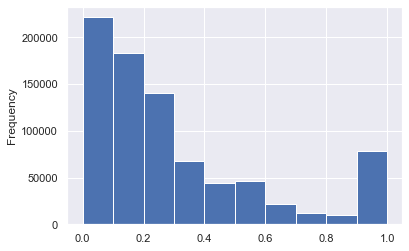

In [97]:
data[~data.is_retweet][['prct_tokens_not_text']+nlpcols].prct_tokens_not_text.plot.hist()

<AxesSubplot:ylabel='Frequency'>

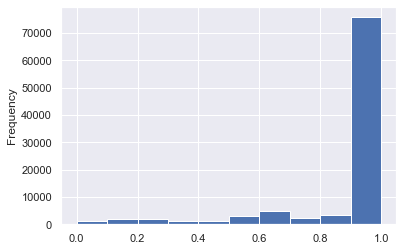

In [98]:
data[~data.is_retweet][['prct_tokens_not_text']+nlpcols][data.lang=='und'].prct_tokens_not_text.plot.hist()

In [99]:
# For now where lang is "und", we set the "conservative" value (language from the user history) where applicable
data.loc[(data['lang_n'].notna()) & (data['lang']=='und'), ['lang']]=data['lang_n']

<a id="data-explo"></a>
# Data exploration, descriptive analysis

In [134]:
# # If we want to skip importation/merging steps
# data=pd.read_csv('data/beltweets_full.csv')

### Tweet count over time 

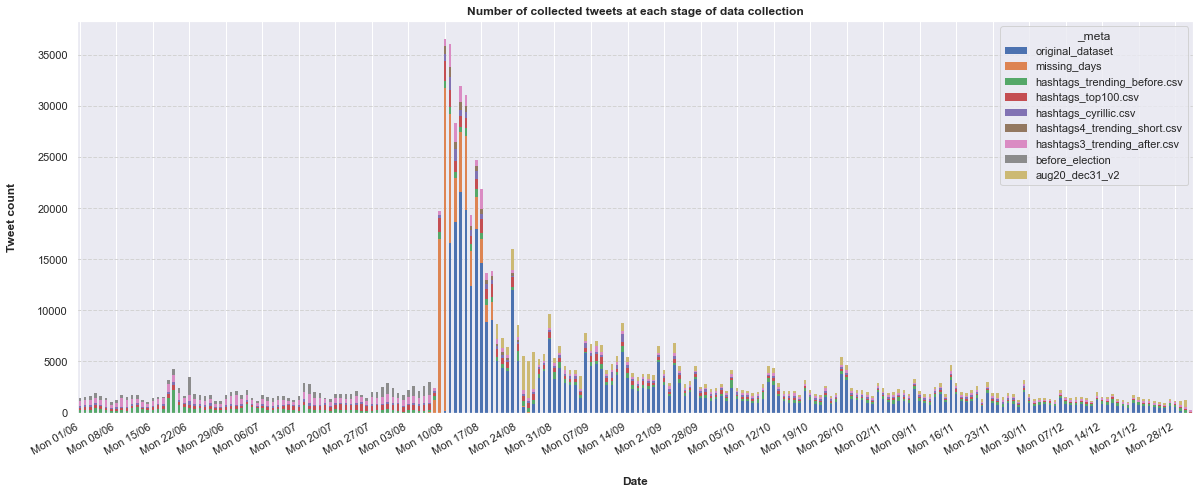

In [100]:
# Plot  data dates
%matplotlib inline
import matplotlib.dates as mdates 
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

toplot = pd.concat([pd.to_datetime(data['created_at']).dt.date, data['_meta']], axis=1)[~data.is_retweet].groupby(["created_at", '_meta']).size().unstack().sort_index(ascending=False, axis=1)

toplot.index=pd.to_datetime(toplot.index).strftime('%a %d/%m')
fig, ax = plt.subplots(figsize=(20,8))
toplot.plot.bar(ax=ax, stacked=True, linewidth=10, edgecolor="none")

plt.title('Number of collected tweets at each stage of data collection', weight='bold', size=12)

# for c in toplot.columns :
#     ax.bar(toplot.index, toplot[c])
# ax.set_xticks(pd.to_datetime(toplot.index).dt.resample('2D'))
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Tweet count", labelpad=20, weight='bold', size=12)
fig.autofmt_xdate()
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(3), interval=1))
plt.show();

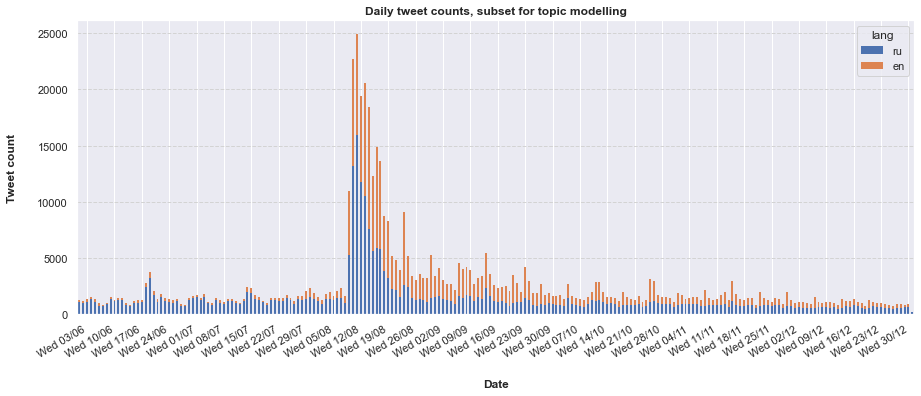

In [101]:
# FOR NLP
# Plot missing data dates
%matplotlib inline
import matplotlib.dates as mdates 
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
toplot = pd.concat([pd.to_datetime(data[((data.lang == 'ru')|(data.lang =='en'))& ~data.is_retweet]['created_at']).dt.date, data[((data.lang == 'ru')|(data.lang =='en'))& ~data.is_retweet]['lang']], axis=1).groupby(["created_at", 'lang']).size().unstack().sort_index(ascending=False, axis=1)

toplot.index=pd.to_datetime(toplot.index).strftime('%a %d/%m')
fig, ax = plt.subplots(figsize=(15, 6))
toplot.plot.bar(ax=ax, stacked=True, linewidth=10, edgecolor="none")

plt.title('Daily tweet counts, subset for topic modelling', weight='bold', size=12)

# for c in toplot.columns :
#     ax.bar(toplot.index, toplot[c])
# ax.set_xticks(pd.to_datetime(toplot.index).dt.resample('2D'))
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Tweet count", labelpad=20, weight='bold', size=12);
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(5), interval=1))
plt.show()

In [102]:
def linebreak(s, k=8) :
    words=s.split()
    i=k
    while i < len(words) :
        words.insert(i, '\n')
        i+=k
    return ' '.join(words)

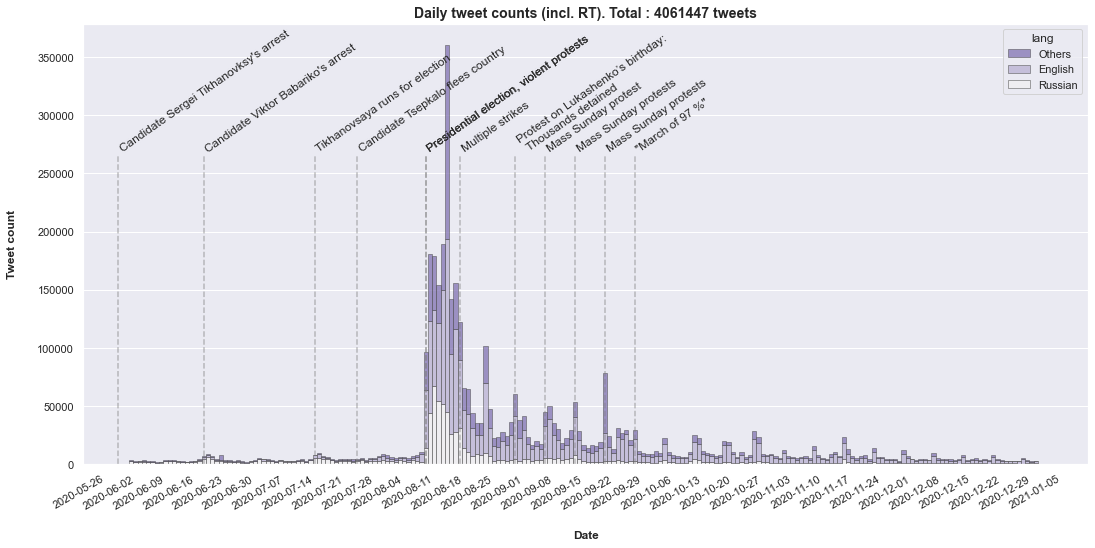

In [103]:
import matplotlib.dates as mdates 
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
toplot=data[['created_at', 'lang']]
toplot['created_at']=toplot['created_at'].dt.date
# toplot['created_at']=toplot['created_at'].dt.strftime('%a %d/%m')
toplot.loc[toplot.lang=='ru', 'lang']='Russian'
toplot.loc[toplot.lang=='en', 'lang']='English'
toplot.loc[~((toplot.lang=='Russian') | (toplot.lang=="English")), 'lang']='Others'
events=pd.read_excel('data/timeline_events_short.xlsx')
events['Date']=pd.to_datetime(events['Date'])
fig, ax = plt.subplots(figsize=(18,9))
sns.histplot(
    toplot,
    x="created_at", hue="lang",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    ax=ax,
    linewidth=.5,
    log_scale=False,
    hue_order=['Others',  "English", "Russian"]
)
plt.grid(visible=1, axis='y', color='white', linestyle='-')
plt.grid(visible=0, axis='x')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(1), interval=1))
for i, (day, event) in enumerate( [tuple(x) for x in events.loc[[0, 1, 3, 5, 9, 9, 14]+list(range(18, 23))][['Date', 'Évènements']].to_numpy()] ):
    ax.axvline(day, color='grey', ymax=0.70, alpha=0.5, linestyle='dashed')
    ax.text(day, 0.74*max(toplot['created_at'].value_counts().values), linebreak(event, 4), rotation=35, horizontalalignment='left', verticalalignment='bottom', fontsize=12)  

plt.title(f'Daily tweet counts (incl. RT). Total : {len(toplot)} tweets', weight='bold', size=14)  
# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Tweet count", labelpad=20, weight='bold', size=12);
plt.show()

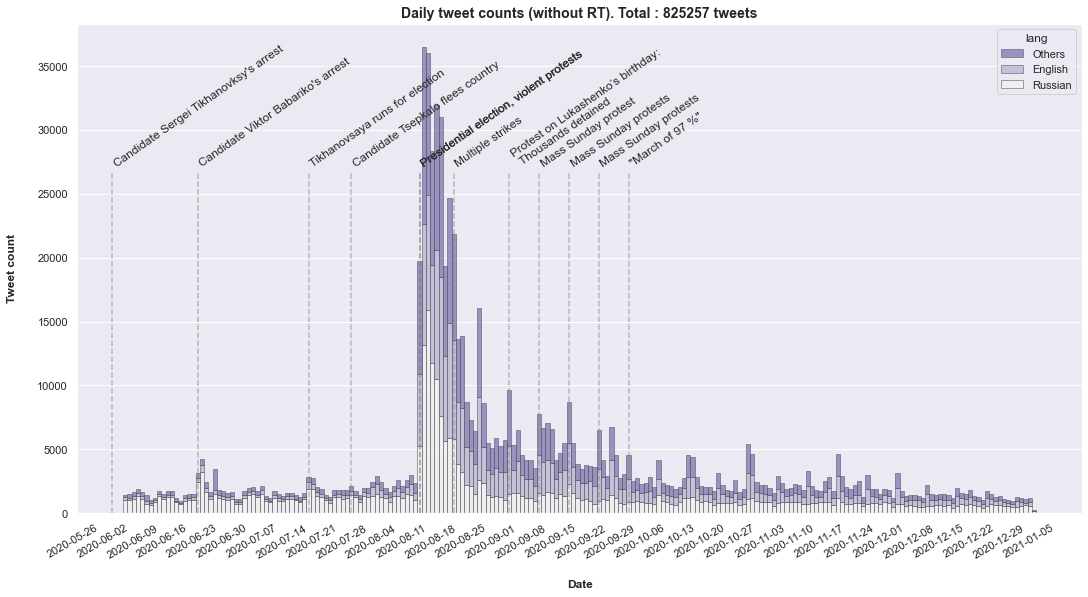

In [104]:
toplot=data[~data.is_retweet][['created_at', 'lang']]
toplot['created_at']=toplot['created_at'].dt.date
toplot.loc[toplot.lang=='ru', 'lang']='Russian'
toplot.loc[toplot.lang=='en', 'lang']='English'
toplot.loc[~((toplot.lang=='Russian') | (toplot.lang=="English")), 'lang']='Others'
events=pd.read_excel('data/timeline_events_short.xlsx')
events['Date']=pd.to_datetime(events['Date'])
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(
    toplot,
    x="created_at", hue="lang",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    ax=ax,
    linewidth=.5,
    log_scale=False,
    hue_order=['Others',  "English", "Russian"]
)
plt.grid(visible=1, axis='y', color='white', linestyle='-')
plt.grid(visible=0, axis='x')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(1), interval=1))
for i, (day, event) in enumerate( [tuple(x) for x in events.loc[[0, 1, 3, 5, 9, 9, 14]+list(range(18, 23))][['Date', 'Évènements']].to_numpy()] ):
    ax.axvline(day, color='grey', ymax=0.70, alpha=0.5, linestyle='dashed')
    ax.text(day, 0.74*max(toplot['created_at'].value_counts().values), linebreak(event, 4), rotation=35, horizontalalignment='left', verticalalignment='bottom', fontsize=12)  

plt.title(f'Daily tweet counts (without RT). Total : {len(toplot)} tweets', weight='bold', size=14)   
# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Tweet count", labelpad=20, weight='bold', size=12);
plt.show()

### Top mentions (tweeted @)

name,count
@HannaLiubakova,305733
@VoicesBelarus,110659
@BFreeTheatre,69809
@nexta_tv,67269
@AlexKokcharov,67195
@Den_2042,66082
@YourAnonCentral,53468
@destiny1529,47258
@AlexandreKrausz,37808
@McFaul,35084


<Figure size 432x288 with 0 Axes>

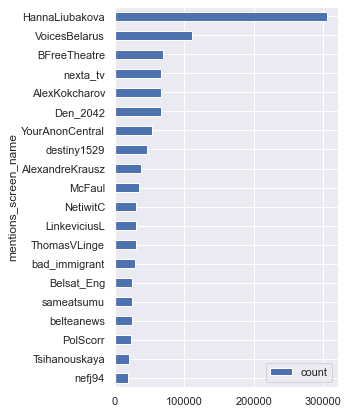

In [105]:
# Check top tweeted at @
s=pd.concat([data.mentions_user_id.str.replace(',', ' ').str.split().explode(),
data.mentions_screen_name.str.replace(',', ' ').str.split().explode()], axis=1)
s=s.value_counts(sort=True).to_frame('count').reset_index()
# s.rename(columns={'mentions_screen_name':'name'}, inplace=True)
def make_clickable(link, val):
    return '<a target="_blank" href="{}">{}</a>'.format(link, val)
s['name']=s.apply(lambda x : make_clickable('https://twitter.com/intent/user?user_id='+x.mentions_user_id, "@"+x.mentions_screen_name), axis=1)
# plot
plt.tight_layout();
s.head(20).set_index('mentions_screen_name').sort_values('count', ascending=True).plot.barh(figsize=(4, 7));

(s.set_index('mentions_user_id')[['name', 'count']]
#show this much in clickable
    .head(20)
    .style.format({'index': "{}"}).hide_index()
)

# warning : ~500 users changed handle during the data collection
# value_counts above returns a count for each (id, username) pair
# if we want to check
# with pd.option_context("display.max_rows", None) :
#     print(pd.concat([
#         data.mentions_screen_name.replace(', ', ' ').str.split().explode().value_counts().to_frame("name").reset_index().head(25),
#         data.mentions_user_id.replace(', ', ' ').str.split().explode().value_counts().to_frame("id").reset_index().head(25)
#     ], axis=1)
#     )

### Retweets

CDF of number of retweets :
* Around 33% retweet rate

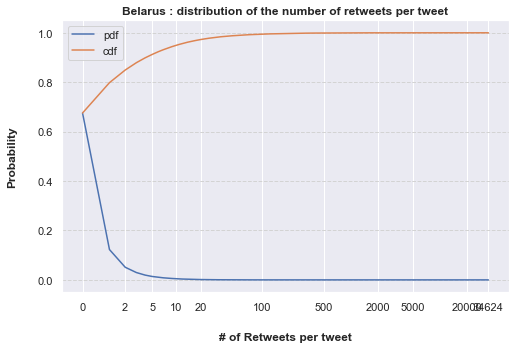

In [106]:
# Get the frequency, PDF and CDF for each value in the series
# Frequency
from matplotlib import ticker
stats_df = data.drop(data[data.is_retweet].index) \
.groupby('retweet_count') \
['retweet_count'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'retweet_count': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df.retweet_count+=1
fig,ax = plt.subplots()
stats_df.plot(ax=ax, x = 'retweet_count', y = ['pdf', 'cdf'], grid = True, figsize=(8,5))
ax.set_xscale('log')
x=[1, 3, 6, 11, 21, 101, 501, 2001, 5001, 20001, max(stats_df.retweet_count)+1]
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x-1)))
ax.xaxis.set_major_locator(ticker.FixedLocator(x))
# ax.set_xticks()
# ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.title('Belarus : distribution of the number of retweets per tweet', weight='bold', size=12)
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# Set x-axis label
ax.set_xlabel("# of Retweets per tweet", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Probability", labelpad=20, weight='bold', size=12);

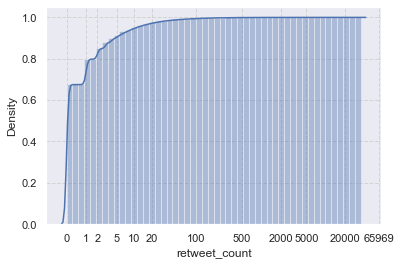

In [107]:
kwargs = {'cumulative': True}
g = sns.distplot(np.log(data.drop(data[data.is_retweet].index)['retweet_count']+1), hist_kws=kwargs, kde_kws=kwargs)
g.set_xticks(np.log([n+1 for n in [0, 1, 2, 5, 10, 20, 100, 500, 2000, 5000, 20000, 65969]]));
g.set_xticklabels([0, 1, 2, 5, 10, 20, 100, 500, 2000, 5000, 20000, 65969]);
g.grid(visible=1, color='lightgray', linestyle='--')

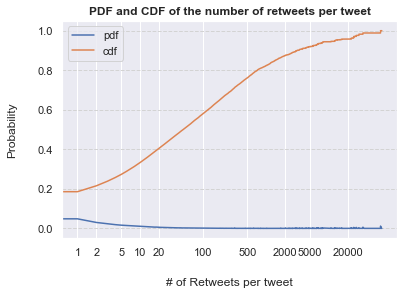

In [108]:
# Get the frequency, PDF and CDF for each value in the series
# Frequency
from matplotlib import ticker
stats_df = data \
.groupby('retweet_count') \
['retweet_count'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'retweet_count': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
fig,ax = plt.subplots()
stats_df.plot(ax=ax, x = 'retweet_count', y = ['pdf', 'cdf'], grid = True, figsize=(6,4))
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 100, 500, 2000, 5000, 20000])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.title('PDF and CDF of the number of retweets per tweet', weight='bold', size=12)
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# Set x-axis label
ax.set_xlabel("# of Retweets per tweet", labelpad=20, size=12)
# Set y-axis label
ax.set_ylabel("Probability", labelpad=20, size=12);

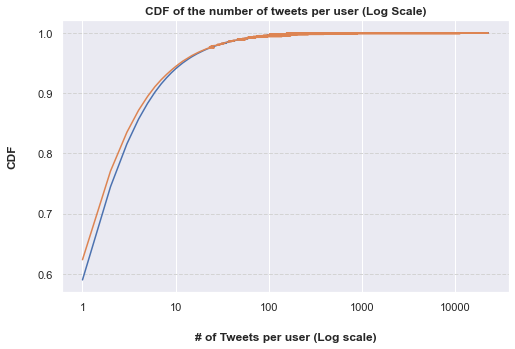

In [109]:
%matplotlib inline
fig,ax=plt.subplots()
data['user_id'].value_counts().value_counts(normalize=True).cumsum().plot(ax=ax, figsize=(6,4), grid=True)
data.drop(data[data.is_retweet].index)['user_id'].value_counts().value_counts(normalize=True).cumsum().plot(ax=ax, figsize=(8,5), grid=True)
# TODO limiter au nombre d'usagers
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
ax.set_xscale('log')
# ax.set_xticks([1, 2, 5, 10, 20, 200, 500, 1000, 5000, 10000])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
# ax.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.title('CDF of the number of tweets per user (Log Scale)', weight='bold', size=12)
# Set x-axis label
ax.set_xlabel("# of Tweets per user (Log scale)", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("CDF", labelpad=20, weight='bold', size=12);
plt.show();

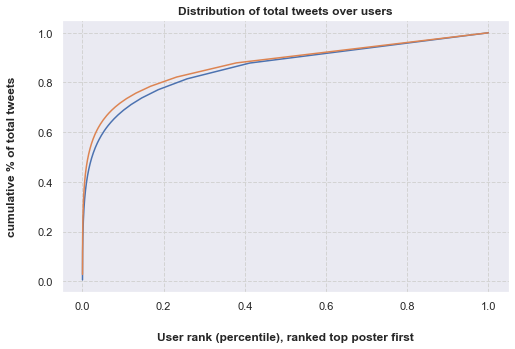

In [110]:
fig,ax=plt.subplots(figsize=(8,5))
toplot= data['user_id'].value_counts().sort_values(ascending=False).cumsum()/len(data)
toplot.index= toplot.rank()/len(toplot)
toplot.plot()
toplot= data[data['is_retweet']==False]['user_id'].value_counts().sort_values(ascending=False).cumsum()/len(data[data['is_retweet']==False])
toplot.index= toplot.rank()/len(toplot)
toplot.plot()
plt.grid(visible=1, color='lightgray', linestyle='--')
plt.title('Distribution of total tweets over users', weight='bold', size=12)
# Set x-axis label
ax.set_xlabel("User rank (percentile), ranked top poster first", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel('cumulative % of total tweets' , labelpad=20, weight='bold', size=12);
plt.show();

Stats of top posters (>500 tweets)

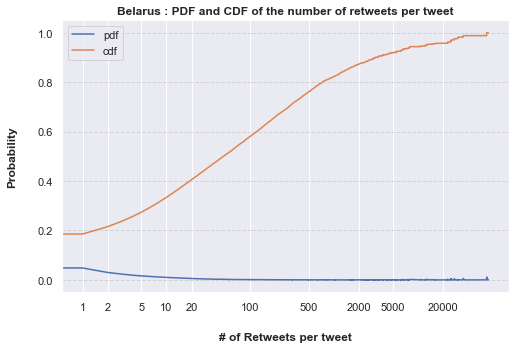

In [111]:
# Get the frequency, PDF and CDF for each value in the series
# Frequency
from matplotlib import ticker
stats_df = data \
.groupby('retweet_count') \
['retweet_count'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'retweet_count': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
fig,ax = plt.subplots()
stats_df.plot(ax=ax, x = 'retweet_count', y = ['pdf', 'cdf'], grid = True, figsize=(8,5))
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 100, 500, 2000, 5000, 20000])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.title('Belarus : PDF and CDF of the number of retweets per tweet', weight='bold', size=12)
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# Set x-axis label
ax.set_xlabel("# of Retweets per tweet", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Probability", labelpad=20, weight='bold', size=12);

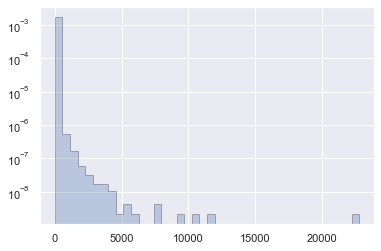

In [112]:
# data['user_id'].value_counts(normalize=True).hist(bins=[0, 1, 2, 5, 10, 50, 100, 1000, 10000], ec=k, density=True)
plt.hist(data['user_id'].value_counts(), histtype='stepfilled', alpha=0.3, bins=40, density=True, ec="k", log=True);

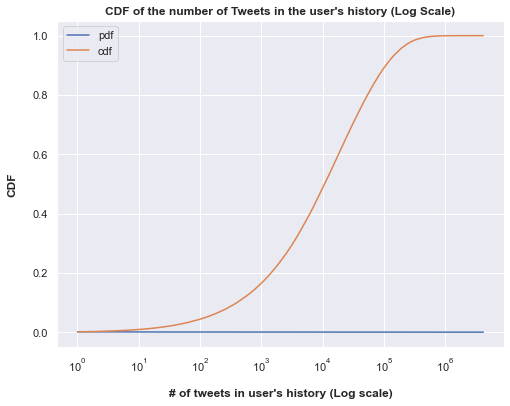

In [113]:
# Get the frequency, PDF and CDF for each value in the series

# Frequency
stats_df = data.drop_duplicates(subset='user_id', keep='last') \
.groupby('statuses_count') \
['statuses_count'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'statuses_count': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()

# Plot
fig, ax = plt.subplots(figsize=(8,6))
stats_df.plot(ax=ax, x = 'statuses_count', y = ['pdf', 'cdf'], grid = True, logx=True)
# ax.set_xscale('log')
# ax.set_xticks([1, 2, 5, 20, 200, 500, 1000, 5000, 10000, 50000])
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.title("CDF of the number of Tweets in the user's history (Log Scale)", weight='bold', size=12)
# Set x-axis label
ax.set_xlabel("# of tweets in user's history (Log scale)", labelpad=15, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("CDF", labelpad=15, weight='bold', size=12);



In [114]:
# Most retweeted users (= most frequent "OP of retweeted tweet" in dataset)
data.groupby('retweet_screen_name').size().sort_values(ascending=False).reset_index().head(50)

,retweet_screen_name,0
0,HannaLiubakova,294126
1,VoicesBelarus,111164
2,BFreeTheatre,65410
3,AlexKokcharov,63323
4,Den_2042,62854
...,...,...
45,A_Sannikov,6508
46,AnonymeCitoyen,6458
47,pipob69,6307
48,Liveuamap,6298


In [115]:
# Users with the most tweets (= most frequent "Username of tweet" in dataset)
data.groupby('screen_name').size().sort_values(ascending=False).reset_index().head(50)

,screen_name,0
0,CoolBeren,22817
1,VoicesBelarus,11640
2,reform_by,10505
3,undos_l,9277
4,PaweGrzegorczy1,7926
...,...,...
45,HekelKortzicht,2196
46,free_Belarus_lv,2175
47,Boo75376987,2156
48,Freecitizen864,2131


In [117]:
def linebreak(s) :
    words=s.split()
    i=10
    while i < len(words) :
        words.insert(i, '\n')
        i+=10
    return ' '.join(words)

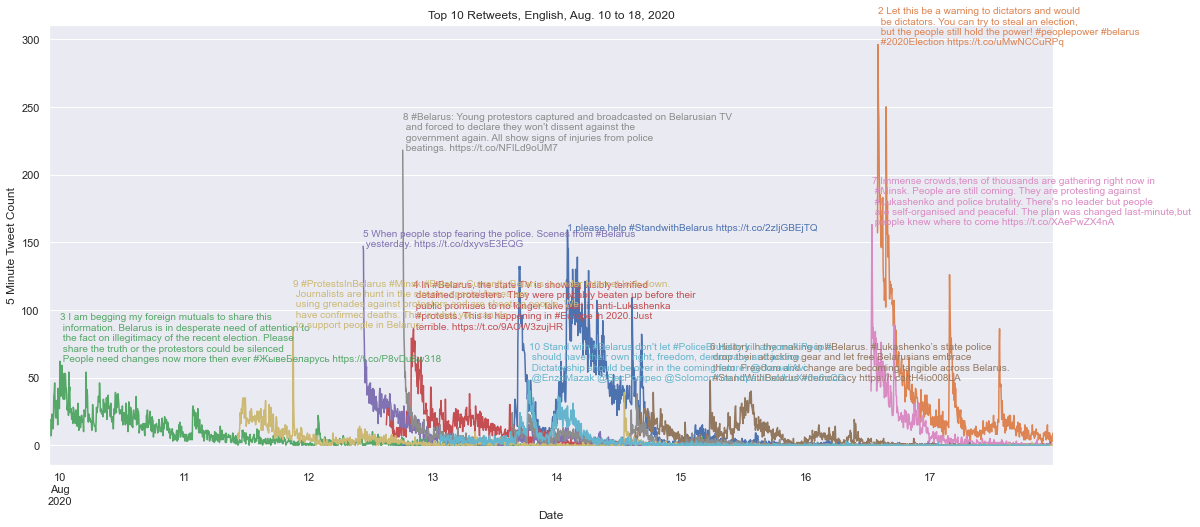

In [118]:
topRT2=data[['status_id', 'created_at', 'retweet_status_id']][(data['lang']=='en')][(data['created_at']>'2020-08-08')&(data['created_at']<'2020-08-18')]\
    .groupby('retweet_status_id').size().sort_values(ascending=False).reset_index()
topcontent=pd.DataFrame()
fig,ax=plt.subplots(figsize=(18, 9))
for top in range(1,11): # top RT is a tweet that contains only hashtags
    tweetid = topRT2.iloc[top].retweet_status_id
    bel_top_retweets = data[["retweet_status_id", "created_at", "text"]+idcols][(data['created_at']>'2020-08-08')&(data['created_at']<'2020-08-18')][data[(data['created_at']>'2020-08-08')&(data['created_at']<'2020-08-18')].retweet_status_id==tweetid]
    g=bel_top_retweets.groupby(\
        pd.Grouper(key='created_at', freq='5Min', convention='start')).size()
    p=g.plot(ax=ax)
    # plt.rc('axes', unicode_minus=False)
    topcontent=pd.concat([topcontent, data[['status_id', 'created_at', 'text']][data['status_id']==tweetid]])
    # # Example : annotate text on max value of the curve
    y=g.max()
    x=g.idxmax()
    # plt.text(x,y, s=linebreak(bel_top_retweets['text'].iloc[0]), color=p.lines[-1].get_color())
    plt.annotate(text=linebreak(str(top)+' '+bel_top_retweets['text'].iloc[0]), xy=(x,y), color=p.lines[-1].get_color())   #Try add   #, wrap=True)
# plt.semilogy(basey=50)
plt.xlabel('Date')
plt.ylabel('5 Minute Tweet Count')
plt.title('Top 10 Retweets, English, Aug. 10 to 18, 2020')
fig.autofmt_xdate()
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(5), interval=1))
plt.show();
# plt.savefig("belarus_top20_retweet_timelines.png")

In [119]:
topRT2.iloc[1]

retweet_status_id    1293585989374484480.0
0                                    17323
Name: 1, dtype: object

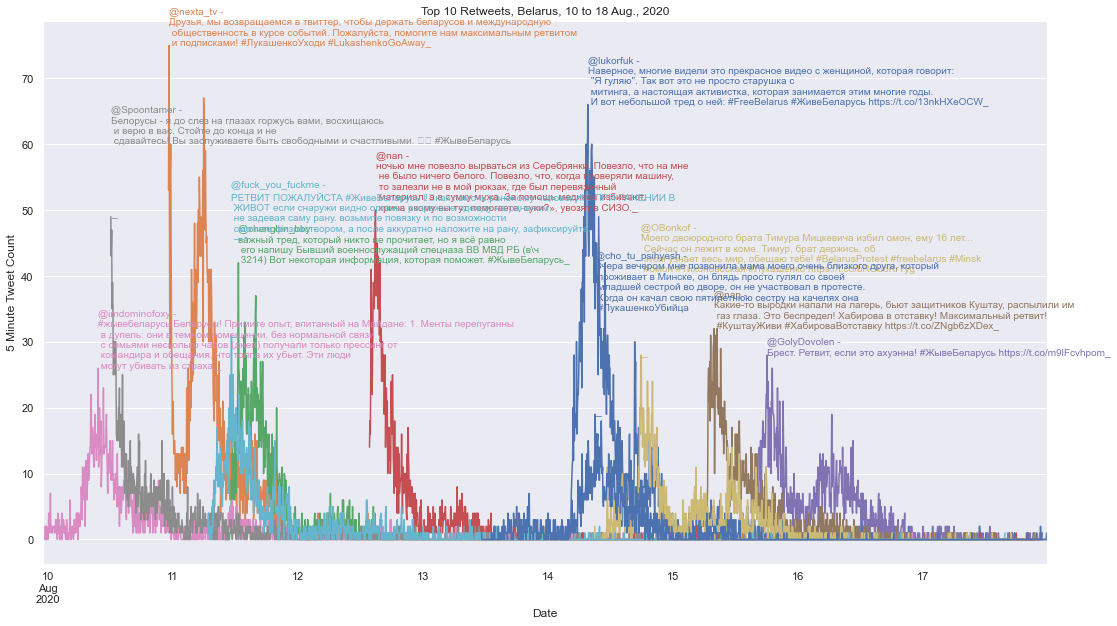

In [120]:
topRT3=data[['status_id', 'created_at', 'retweet_status_id']][(data['lang']=='ru')][(data['created_at']>'2020-08-08')&(data['created_at']<'2020-08-18')].groupby('retweet_status_id').size().sort_values(ascending=False).reset_index()
topcontent=pd.DataFrame()
for top in range(0,11):
    tweetid = topRT3.iloc[top].retweet_status_id
    bel_top_retweets = data[["retweet_status_id",'retweet_screen_name']+botcols][(data['created_at']>'2020-08-08')&(data['created_at']<'2020-08-18')][data[(data['created_at']>'2020-08-08')&(data['created_at']<'2020-08-18')].retweet_status_id==tweetid]
    g=bel_top_retweets.groupby(\
        pd.Grouper(key='created_at', freq='5Min', convention='start')).size()
    p=g.plot(figsize=(18,10))
    topcontent=pd.concat([topcontent, data[['status_id', 'created_at', 'text']][data['status_id']==tweetid]])
    # # Example : annotate text on max value of the curve
    y=g.max()
    x=g.idxmax()
    nlines=0
    if top>=7 :
        nlines=top
    plt.annotate(text='@'+str(bel_top_retweets['retweet_screen_name'].iloc[0])+' -\n'+linebreak(bel_top_retweets['text'].iloc[0])+(nlines*'\n')+'_', xy=(x,y), color=p.lines[-1].get_color())   #Try add   #, wrap=True)
# plt.semilogy(basey=50)
plt.xlabel('Date')
plt.ylabel('5 Minute Tweet Count')
plt.title('Top 10 Retweets, Belarus, 10 to 18 Aug., 2020');
# plt.savefig("belarus_top20_retweet_timelines.png")

### URLS

### Locations and geo
Entire exploration of geographical features was done in a separate notebook

### Account creations

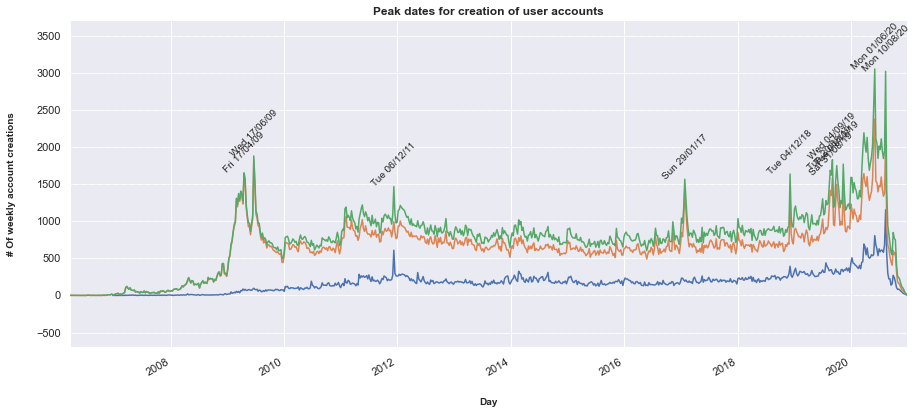

In [124]:

fig, ax = plt.subplots(figsize=(15,6))
d= data[data.lang=='ru'][['account_created_at', 'user_id']].drop_duplicates(subset="user_id", keep="first")['account_created_at'].dt.date.value_counts().sort_index()
d.index=(pd.to_datetime(d.index))
d=d['2006-01-01':]
d.resample('1W').sum().plot(ax=ax, alpha=1)

# Account creation
# First 3 months

d= data[data.lang=='en'][['account_created_at', 'user_id']].drop_duplicates(subset="user_id", keep="first")['account_created_at'].dt.date.value_counts().sort_index()
d.index=(pd.to_datetime(d.index))
d=d['2006-01-01':]
d.resample('1W').sum().plot(ax=ax, alpha=1)

# Account creation
# First 3 months
d= data[(data.lang=='ru') | (data.lang=='en')][['account_created_at', 'user_id']].drop_duplicates(subset="user_id", keep="first")['account_created_at'].dt.date.value_counts().sort_index()
d.index=(pd.to_datetime(d.index))
d=d['2006-01-01':]
# d.plot.bar(ax=ax, color='lightgray', edgecolor='gray')
d.resample('1W').sum().plot(ax=ax, alpha=1)
x=ax
# Set X Scale as log
# x.set_xscale('log')

# Despine
x.spines['right'].set_visible(False)
x.spines['top'].set_visible(False)
x.spines['left'].set_visible(False)

# Switch off ticks
# x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
from scipy.signal import find_peaks
peaks,dict = find_peaks(d, prominence=150)
for p in peaks :
    ax.annotate((d.index[p].strftime('%a %d/%m/%y')), (d.index[p],d.resample('1W', kind='period').sum().loc[d.index[p]]), size=10, rotation=45, horizontalalignment='center')
# d.plot.bar(ax=ax, color='lightgray', edgecolor='gray')
# Draw horizontal axis lines
vals = x.get_yticks()
for tick in vals:
    x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
# Remove title
x.set_title("Peak dates for creation of user accounts", weight='bold', size=12)
# Set x-axis label
x.set_xlabel("Day", labelpad=20, weight='bold', size=10)
# Set y-axis label
x.set_ylabel("# Of weekly account creations", labelpad=20, weight='bold', size=10)
plt.locator_params(axis="x", nbins=45)
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')



In [125]:
# TOP Dates of account creations
data['account_created_at'].dt.date.value_counts().head(20)

2014-09-09    23306
2020-08-10    14329
2020-07-02    13600
2016-06-10    11017
2014-02-26    10377
              ...  
2010-09-26     5414
2014-03-04     5411
2020-08-13     5364
2020-04-06     5085
2019-09-04     5075
Name: account_created_at, Length: 20, dtype: int64

# Exports

## Exports for Geo data

In [126]:
geocols=['status_id', 'user_id', 'created_at', 'text', 'name', 'location', 'quoted_location', 'retweet_location','place_url', 'place_name', 'place_full_name', 'place_type', 'geo.id', 'country', 'country_code', 'coords_coords', 'bbox_coords']

In [ ]:
data[['status_id', 'location']].set_index('status_id').to_csv("data/beltweets_userlocations.csv")

In [ ]:
# data[geocols].to_csv('tweets_geo.csv')

In [130]:
data.to_csv('data/beltweets_full.csv')

## Export for NLP

In [131]:
# Columns that we want to keep for NLP
nlpcols=['text',
 'created_at',
 'lang',
#  # add this to compare inferred language
#  'lang_n', 
#  'lang_spacy',
#  'lang_spacy_score',
#  'lang_user_n',
#  'lang_user_zscore',
#  # /add this to compare inferred language
 'n_tweets',
 'retweet_count',
#  'RT_to_tweets',
#  'mean_freq',
 'name',
 'screen_name',
 'description',
 'hashtags',
 'status_id',
 'user_id',
 '_meta']

In [132]:
nlp_out = data[~(data.is_retweet)&data['lang'].isin(['en', 'ru', 'und'])][nlpcols+['retweet_status_id']]
nlp_out=nlp_out.set_index(pd.DatetimeIndex(nlp_out.created_at))['2020-06-01':].reset_index(drop=True)
nlp_out=nlp_out.set_index('status_id', drop=True)
nlp_out=nlp_out[nlp_out['lang'].isin(['en', 'ru'])]
nlp_out['text']=nlp_out['text'].str.replace(r'\\n', ' ', regex=True)
nlp_out.to_csv('data/beltweets_nlp.csv')
print('exported ' + str(len(nlp_out))+ ' tweets for topic modeling (RU and EN)')

exported 548827 tweets for topic modeling (RU and EN)


In [267]:
nlp_out_RT = data[data['lang'].isin(['en', 'ru'])][nlpcols+['retweet_status_id']].set_index('status_id', drop=True)
nlp_out_RT=nlp_out_RT.set_index(pd.DatetimeIndex(nlp_out_RT.created_at))['2020-06-01':].reset_index(drop=True)
nlp_out_RT['text']=nlp_out_RT['text'].str.replace(r'\\n', ' ', regex=True)
nlp_out_RT.to_csv('beltweets_nlp_RT.csv')
print('exported ' + str(len(nlp_out_RT))+ ' tweets')

Export adding the detected languages

In [ ]:

# Where lang is "und", set the value where applicable
data.loc[(data['lang_n'].isna()) & (data['lang']=='und') & (data.prct_tokens_not_text<0.7) & (data.lang_spacy_score>=0.7), ['lang']]=data['lang_spacy']
nlp_out = data[~(data.is_retweet)&data['lang'].isin(['en', 'ru'])][nlpcols+['retweet_status_id']]
nlp_out=nlp_out.set_index(pd.DatetimeIndex(nlp_out.created_at))['2020-06-01':].reset_index(drop=True)
nlp_out=nlp_out.set_index('status_id', drop=True)
# nlp_out.to_csv('data/beltweets_nlp_w_und.csv')
# print('exported ' + str(len(nlp_out))+ ' tweets (including UND language)')
nlp_out=nlp_out[nlp_out['lang'].isin(['en', 'ru'])]
nlp_out.to_csv('data/beltweets_nlp_incl_detectedlangs.csv')

print (f'exported {len(nlp_out)} tweets after including those detected as russian and english')

exported 554294 tweets after including those detected as russian and english


Export "und" language tweets

In [ ]:
nlpcols.remove('lang_n')

In [ ]:
und_tweets = data[~(data.is_retweet)&(data['lang']=='und')][nlpcols+['retweet_status_id']]
und_tweets=und_tweets.set_index(pd.DatetimeIndex(und_tweets.created_at))['2020-06-01':].reset_index(drop=True)
# und_tweets['text']=und_tweets['text'].str.replace(r'\\n', ' ', regex=True)
# und_tweets['text']=und_tweets['text'].str.replace("\n\r","")
# und_tweets['text']=und_tweets['text'].str.replace("\r","")

In [ ]:
und_tweets[['status_id','text']].set_index('status_id').to_csv('und_tweets.csv')
print('exported ' + str(len(und_tweets))+ ' tweets with undetected lang')

exported 97154 tweets with undetected lang


# Early steps (for archival)

## Removing tweets using annotations ?
* Tweets are annotated
* We assess this is not accurate enough for the benefit ? (11k tweets with "sports" domain but a lot are still relevant)

In [ ]:
# TODO delete : entities.annoations is in [Beijing Olympics, Dinamo Minsk], contains 'Dynamo' or "Dinamo"...

In [ ]:
# [a.keys() for a in \
#     data[~data.is_retweet][['text', 'context_annotations', 'entities.annotations']].dropna(how='any')['context_annotations']\
#         .iloc[100]
# ]

In [ ]:
# data[botcols+['context_annotations', 'entities.annotations']][mask]['entities.annotations'].dropna()\
#     .apply(lambda x: [a['normalized_text'] for a in x])\
#         .explode().value_counts().to_dict()

In [ ]:
# data[botcols+['context_annotations', 'entities.annotations']][mask].dropna(how='any')['entities.annotations']\
#     .apply(lambda x: [a['normalized_text'] for a in x]).explode().value_counts().to_dict()

In [ ]:
# # Create mask based on annotated domains
# # We parse the entire annotation
# mask = data[['text', 'context_annotations', 'entities.annotations']]['context_annotations'].astype(str)\
#     .str.contains(r'(?<!tran)sport', na=False, case=False)

In [ ]:
# # Display annotations counts
# data[~data.is_retweet][['text', 'context_annotations', 'entities.annotations']].dropna(how='any')['context_annotations']\
#     .apply(lambda x: ['Domain : ' + a['domain']['name']+ ' ; Entity : ' + a['entity']['name'] for a in x]).explode().value_counts().to_dict()

In [ ]:
# data[~data.is_retweet][['text', 'context_annotations', 'entities.annotations']].dropna(how='any')['entities.annotations']\
#     .apply(lambda x: [a['normalized_text'] for a in x]).explode().

In [ ]:
# data[~data.is_retweet][['text', 'context_annotations', 'entities.annotations']].dropna(how='any')['entities.annotations']\
#     .apply(lambda x: [a['normalized_text'] for a in x]).explode().value_counts().to_dict()

In [ ]:
#TODO Standardize carriage returns, because Twitter doesn’t.
#Both \r\n and \n can appear in tweets. When creating a CSV from the JSON response, however, this can cause problems. 
# A CSV with two separate line endings will confuse pandas and goes against agreed on standards. Perhaps the easiest way to handle this is using python’s repr function to explicitly include special characters in the string. This would force everything into one line and prevent confusion:

### STats on rare languages ?

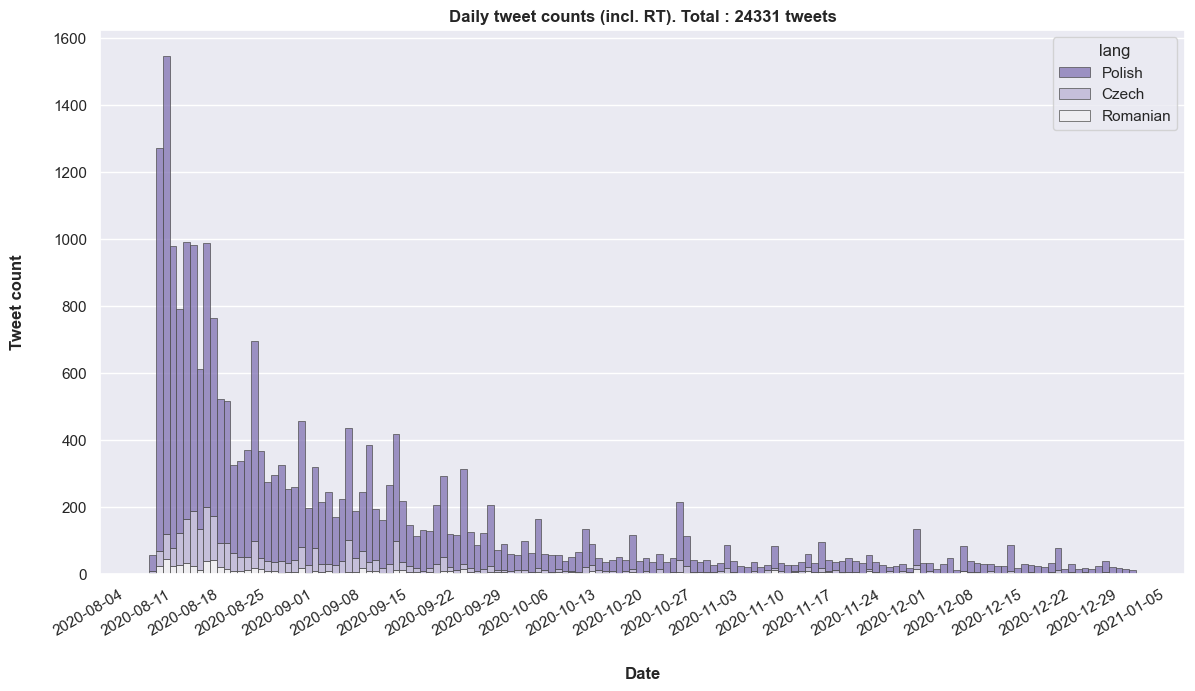

In [ ]:
import matplotlib.dates as mdates 
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
toplot=data[['created_at', 'lang']][data.lang.isin(['pl', 'cs', 'ro'])][~data.is_retweet]
# toplot['created_at']=toplot['created_at'].dt.date
toplot=toplot.set_index('created_at')["08-08-2020":].reset_index()
toplot['created_at']=toplot['created_at'].dt.date
toplot.loc[toplot.lang=='pl', 'lang']='Polish'
toplot.loc[toplot.lang=='cs', 'lang']='Czech'
toplot.loc[toplot.lang=='ro', 'lang']='Romanian'
# toplot['created_at']=toplot['created_at'].dt.strftime('%a %d/%m')
# toplot.loc[toplot.is_retweet, 'is_retweet']='Retweets'
# toplot.loc[~toplot.is_retweet, 'is_retweet']='Tweets'
# toplot.loc[~((toplot.lang=='Polish') | (toplot.lang=="Czech")), 'lang']='Others'
events=pd.read_excel('data/timeline_events_short.xlsx')
events['Date']=pd.to_datetime(events['Date'])
fig, ax = plt.subplots(figsize=(14,8))
sns.histplot(
    toplot,
    x="created_at", hue="lang",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    ax=ax,
    linewidth=.5,
    log_scale=False,
    # hue_order=['Others',  "Polish", "Czech"]
)
plt.grid(visible=1, axis='y', color='white', linestyle='-')
plt.grid(visible=0, axis='x')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(1), interval=1))
# for i, (day, event) in enumerate( [tuple(x) for x in events.loc[[0, 1, 3, 5, 9, 9, 14]+list(range(18, 23))][['Date', 'Évènements']].to_numpy()] ):
#     ax.axvline(day, color='grey', ymax=0.70, alpha=0.5, linestyle='dashed')
#     ax.text(day, 0.74*max(toplot['created_at'].value_counts().values), linebreak(event, 4), rotation=35, horizontalalignment='left', verticalalignment='bottom', fontsize=10)  

plt.title(f'Daily tweet counts (incl. RT). Total : {len(toplot)} tweets', weight='bold', size=12)  
# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Tweet count", labelpad=20, weight='bold', size=12);
plt.show()

### Keyword augmentation
Extraction of top hashtags, top cyrillic hashtags, from our data at an earlier stage

Extracting missing hashtags<a id='missing_hashtags'></a>


In [ ]:
# Extract hashtags from twitter JSON (for V2) 
def flatten_hashtags(list_of_dict) :
    if pd.notna(list_of_dict) :
        l = eval(list_of_dict)
        tags = ' '.join([d["tag"] for d in l]).lower()
    else :
        tags = None
    return tags

In [ ]:
# Hashtags are sometimes undetected from the tweet's text (in V1 systematically, in V2 often)
n=np.random.randint(0, 1999)
sample=data[['text', 'hashtags']].sample(n=10, random_state=n)[data.sample(n=10, random_state=n)['hashtags'].isna()]

print(sample)

# Function based on regex to extract them
def extract_hashtags(text) :
    # h = re.findall(r'#\S+', text) # Extract including "#" character
    h = re.findall(r'#(\w+)', text)
    h.extend(re.findall(r'# (\w+)', text))
    if ' '.join(h) == '' :
        return np.nan
    else :
        return ' '.join(h).lower()
# Example
extract_hashtags(sample['text'].iloc[0])
# extract_hashtags('sample # belarus #test')

                                                                                                                                                                                                                                                                                                    text  \
1081695                                                                                                                                         Стоило бы прислушаться.\n\nДжохар Дудаев расскрывает планы России по отношению к Беларуси и Украине. 1995 год. \n\n#ЖывеБелорусь https://t.co/uK2htRXa39   
1087574  The Ministry of Internal Affairs explained the reason for using water cannons in Brest: "about a thousand people were dancing round dances and this became a serious threat to traffic safety»\nYou can see how this dance looked:\n\n#StandWithBelarus source:@svaboda https://t.co/lmB0YOTQzi   

        hashtags  
1081695      NaN  
1087574      NaN  


'жывебелорусь'

In [ ]:
# # # Apply to V1
print('hashtags missing total : '+str(len(data[data['hashtags'].isna()]))+ '\n extracting hashtags from text (V1)...')
# print ('hashtags missing in original dataset ' + str(len(data[(data['new_hashtags'].notna()) & (data['hashtags'].isna())])) + ' tweets with undetected hashtags')
# # # Replacing with newfound hashtags
data['hashtags'] = data.apply(lambda x: extract_hashtags(x['text']) if x['_meta']=='original_dataset' and isinstance(x['hashtags'], str) else x['hashtags'], axis=1)
print('hashtags missing after : '+str(len(data['hashtags'][data['hashtags'].isna()]))+ ', applying to rest of dataset...')
# # Apply to missing hashtags in dataset
# data['hashtags'] = data.apply(lambda x: extract_hashtags(x['text']) if x['_meta']!='original_dataset' and not isinstance(x['hashtags'], str) else x['hashtags'], axis=1)
# print('hashtags missing after : '+str(len(data['hashtags'][data['hashtags'].isna()])))
# Apply to all dataset since the result seems better
data['hashtags_nw'] = data['text'].apply(lambda x: extract_hashtags(x))
print('hashtags missing after : '+str(len(data['hashtags_nw'][data['hashtags_nw'].isna()])) + '. Merging newfound and existing hashtags....')
data['hashtags']=data['hashtags'].str.cat(data['hashtags_nw'], sep=' ', na_rep='').apply(lambda x : ' '.join(list(dict.fromkeys(x.split(' ')))))
print('hashtags missing after : '+str(len(data['hashtags'][data['hashtags'].isna()])))
data['hashtags']=data['hashtags'].str.cat(data['hashtags_nw'], sep=' ', na_rep='').apply(lambda x : ' '.join(list(dict.fromkeys(x.split(' ')))))

In [ ]:
# # Collect missing hashtags and flatten JSON from entire dataset
# # /!\ very long, try to import CSVs with a consistent `hashtag` column, TODO see v1_v2_csv_converter to extract from JSON
# data['hashtags']=data.sort_values(['hashtags', 'entities.hashtags']).apply(lambda x: flatten_hashtags(x['entities.hashtags']) if x['_meta']!='original_dataset'\
#      else x['hashtags'].lower() if isinstance(x['hashtags'], str) else extract_hashtags(x['text']), axis=1)

In [ ]:
# Normalize and lower hashtags (get rid of special fonts such as 𝕭𝖊𝖑𝖆𝖗𝖚𝖘)
from functools import partial
import unicodedata
normalize = partial(unicodedata.normalize, 'NFKD')
data['hashtags']=data.apply(lambda x: normalize(x['hashtags']).lower() if type(x['hashtags']) ==str else x['hashtags'], axis=1)

In [ ]:
# Finally parse hashtags as lists
data['hashtags']=data['hashtags'].str.split(' ')

Finding new hashtags
* We compute the top hashtag by frequency in the dataset, excluding those were part of our original data collection
* We pick the top 100 hashtags fit for a second collection (see `new_hashtags.py`)
* In addition, we identify and collect top 100 hashtags in cyrillic language in hope to balance the dataset (see `new_hashtags.py`)
* We also collect tweets containing hashtags and keywords that were trending in Belarus during the protest, collected from websites that archive twitter trends 

  * > trending = ['psiphon', 'Корж', 'Коржа', 'Окрестина', 'Жодино',
'МЗКТ', 'Латушко', 'дзякуй', 'Окрестино', 'Реальный Брест', 'Пушкинской', '#belarussolidarity']
  * > trending_short = ['молотова', 'СИЗО', "#выборы"]

In [ ]:
# Comparing with our original hashtags
queries = ["(#Minska OR #LukashenkoOut OR #BelarusStrong OR #LukashenkoLeaveNow OR #лукашенкоубийца OR #БеларусьРеволюція)",
"(#belarus OR #minsk OR #ЛукашенкоУходи OR #LukashenkoGoAway OR #BelarusProtest OR #BelarusProtests OR #FreeBelarus OR #zhyvebelarus OR #ЖывеБеларусь OR #prayforbelarus OR #helpbelarus OR #freebelarus OR #freedombelarus OR #savebelarus)" ,
"(#BelarusFreedom OR #Belarus2020 OR #Lukashenko OR #Belaruslivesmatter OR #BelarusSolidarity OR #FreedomforBelarus OR #ЖывэБеларусь OR #ЖивеБеларусь OR #Беларусь  OR #Беларусь2020  OR #LongLiveBelarus  OR #Уходи  OR #автозак)",
"(#лукашенковавтозак OR #ЖывеБелорусь OR #жыве_беларусь OR #лошкипетушки OR #Белoрусь OR #Минск OR #ЖивеБілорусь #MinskMaidan)",
"(#belaruselections OR #belaruselections2020 OR #LukashenkoLeave OR #Minskprotests OR #standwithbelarus OR #BelarusRevolution OR #BelarusWatch OR #belarusstrike OR #ЛукашескуТыСледующий)",
"(#ЛукашенкоДиктатор OR #лукашенкокровавыйдиктатор OR #лукашенкокровавыйубийца OR #ЛукашенкоДиктатор OR #Лукашеску OR #кровавыйтаракан OR #СтопТаракан OR #сашатрипроцента)",
"(#she4belarus OR #беларуски_против_диктатуры OR #беларускі_супраць_дыктатуры)"]
# Extracting hashtags from request list
hashtags = re.findall(r'#(\w+)', ' '.join([q[:-1]for q in queries]))
# Converting for lowercase for finding new hashtags
hashtags = [h.lower() for h in hashtags]
print(hashtags)
# Add newly collected hashtags
from new_hashtags import new_h, h_cyrillic
hashtags.extend(new_h)
hashtags.extend(h_cyrillic)

['minska', 'lukashenkoout', 'belarusstrong', 'lukashenkoleavenow', 'лукашенкоубийца', 'беларусьреволюція', 'belarus', 'minsk', 'лукашенкоуходи', 'lukashenkogoaway', 'belarusprotest', 'belarusprotests', 'freebelarus', 'zhyvebelarus', 'жывебеларусь', 'prayforbelarus', 'helpbelarus', 'freebelarus', 'freedombelarus', 'savebelarus', 'belarusfreedom', 'belarus2020', 'lukashenko', 'belaruslivesmatter', 'belarussolidarity', 'freedomforbelarus', 'жывэбеларусь', 'живебеларусь', 'беларусь', 'беларусь2020', 'longlivebelarus', 'уходи', 'автозак', 'лукашенковавтозак', 'жывебелорусь', 'жыве_беларусь', 'лошкипетушки', 'белoрусь', 'минск', 'живебілорусь', 'minskmaidan', 'belaruselections', 'belaruselections2020', 'lukashenkoleave', 'minskprotests', 'standwithbelarus', 'belarusrevolution', 'belaruswatch', 'belarusstrike', 'лукашескутыследующий', 'лукашенкодиктатор', 'лукашенкокровавыйдиктатор', 'лукашенкокровавыйубийца', 'лукашенкодиктатор', 'лукашеску', 'кровавыйтаракан', 'стоптаракан', 'сашатрипроцент

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3627 (\N{THAI CHARACTER HO HIP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


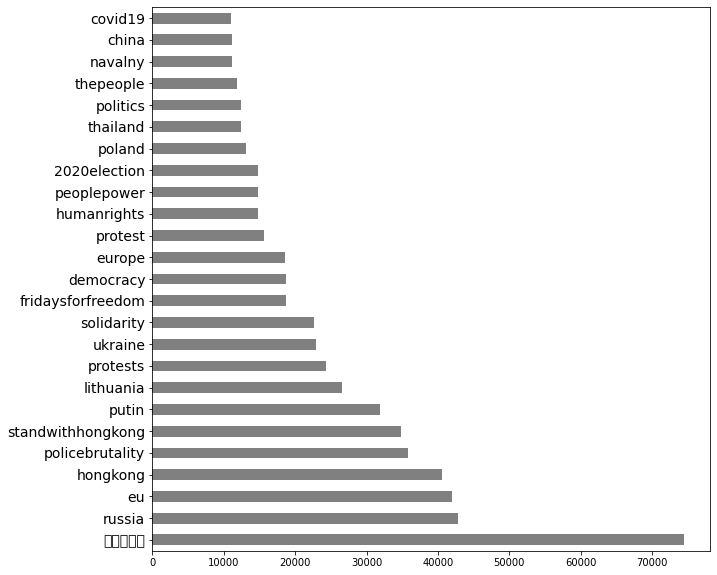

In [ ]:
# Looking for frequent hashtags that weren't in the original collection
hcount.drop(hcount[hcount.index.isin(hashtags)].index, axis=0).head(25).plot.barh(figsize=(10, 10), color='gray', width = 0.5)
# ax.rcParams['ytick.labelsize'] = 15.0
plt.yticks(fontsize=14)
plt.show()

## Geo (places annotations)

In [ ]:
data['entities.annotations'].dropna().apply(lambda x: any([ent['type']=='Place' for ent in x]))

203         True
275         True
279         True
282         True
317         True
           ...  
4288504     True
4291252     True
4304639     True
4307621     True
4311386    False
Name: entities.annotations, Length: 935917, dtype: bool

In [ ]:
data[['place_url', 'place_name', 'place_full_name', 'place_type', 'geo.id', 'country', 'country_code', 'coords_coords', 'bbox_coords']].dropna(how='all')

,place_url,place_name,place_full_name,place_type,geo.id,country,country_code,coords_coords,bbox_coords
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
...,...,...,...,...,...,...,...,...,...
4321422,NaN,Pilsen,"Pilsen, République Tchèque",city,01c24ceb2b5ba900,République Tchèque,CZ,NaN,"[13.2691258, 49.677488, 13.4759158, 49.8058188]"
4321567,NaN,Biélorussie,Biélorussie,country,333a5811d6b0c1cb,Biélorussie,BY,NaN,"[23.179217, 51.2626423, 32.7769812, 56.1717339]"
4321704,NaN,Tallinn,"Tallinn, Estonie",city,cba60fe77bc80469,Estonie,EE,NaN,"[24.5501404, 59.3518286, 24.9262886, 59.4981855]"
4321724,NaN,Biélorussie,Biélorussie,country,333a5811d6b0c1cb,Biélorussie,BY,NaN,"[23.179217, 51.2626423, 32.7769812, 56.1717339]"


In [ ]:
[print(l, c) for c,l in data[['location', 'user_id']].dropna().drop_duplicates(subset='user_id', keep='first')['location'].value_counts()[:30].items()];

4181 United States
3446 Thailand
3248 Москва, Россия
3152 Hong Kong
3103 London, England
3026 ประเทศไทย
2567 she/her
2520 Россия
2506 London
2359 France
2266 Lagos, Nigeria
2118 Venezuela
2084 California, USA
2023 Paris, France
1986 Bangkok, Thailand
1935 Беларусь
1839 Санкт-Петербург, Россия
1806 Los Angeles, CA
1738 Ukraine
1719 Washington, DC
1628 กรุงเทพมหานคร, ประเทศไทย
1504 Nigeria
1501 Украина
1487 Москва
1476 Berlin
1467 Deutschland
1466 USA
1430 United Kingdom
1389 Berlin, Deutschland
1297 Polska


In [ ]:
data[~data.is_retweet][['quoted_location', 'location', 'retweet_location','place_url', 'place_name', 'place_full_name', 'place_type', 'geo.id', 'country', 'country_code', 'coords_coords', 'bbox_coords']].dropna(how='all')

,quoted_location,location,retweet_location,place_url,place_name,place_full_name,place_type,geo.id,country,country_code,coords_coords,bbox_coords
2,NaN,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
8,NaN,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
12,"Kyiv, Ukraine | Brooklyn, NY",Polska,NaN,https://api.twitter.com/1.1/geo/id/333a5811d6b0c1cb.json,Republic of Belarus,Republic of Belarus,country,333a5811d6b0c1cb,Republic of Belarus,BY,NA NA,23.179217 32.7769812 32.7769812 23.179217 51.2626423 51.2626423 56.1717339 56.1717339
16,NaN,"Vic, Spain",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
17,NaN,"Vic, Spain",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA NA NA NA NA NA NA
...,...,...,...,...,...,...,...,...,...,...,...,...
4321806,NaN,Минск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4321808,NaN,Biélorussie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4321809,NaN,云深 不知 处,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4321811,NaN,Витебск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking suspicious accounts with botometer

In [ ]:
# # create a sample of 500 top posters. Sort them by size
# from unidecode import unidecode
# sample = data[botcols]\
#     [data['n_tweets']>=10]\
#     .sort_values('RT_to_tweets', ascending=False)\
#     .sort_values('n_tweets', key=lambda col: pd.cut(col, bins=np.concatenate([np.linspace(0, 1000, num=10), np.linspace(1001, 12000, num=6)], axis=0)), ascending=False)\
#     .sort_values('mean_freq')\
#     .groupby('user_id').head(1).head(40)\
#     # .join(top_posters.set_index('user_id', drop=True)[['bot_score', 'raw_bot_score']], on='user_id')\
#     # [['text', 'created_at', 'is_retweet', 'n_tweets', 'name', 'screen_name', 'source', 'description',\
#     #  'quoted_description', 'retweet_description', 'bot_score', 'raw_bot_score', 'lang', 'mean_freq','status_id', 'user_id']]
# # sample[sample['name'].str.cat(sample[['screen_name', 'description', 'source']], sep=' ', na_rep='').apply(lambda x: unidecode(x).lower()).str.contains(r'(?<![a-zA-Z])bot(?![a-zA-Z])')]
# sample

In [ ]:
# import botometer
# import yaml
# import time
# with open("config.yaml", 'r') as stream:
#     config = yaml.safe_load(stream)

# rapidapi_key = config['rapidapi_key']
# twitter_app_auth = {
#     'consumer_key': config['api_key'],
#     'consumer_secret': config['api_secret'],
#     # 'access_token': config['access_token'],
#     # 'access_token_secret': config['access_token_secret'],
# }
# bom = botometer.Botometer(wait_on_ratelimit=True,
#                         rapidapi_key=rapidapi_key,
#                         **twitter_app_auth)

#     # Check a single account by screen name
#     # result = bom.check_account('@clayadavis')
# def get_bot_scores(userid) :
#     # Check a single account by id
#     return(bom.check_account(userid))
#     # # Check a sequence of accounts
#     # accounts = ['@clayadavis', '@onurvarol', '@jabawack']
#     # for screen_name, result in bom.check_accounts_in(accounts):
#     #     # Do stuff with `screen_name` and `result`
#     #     print(screen_name, result['universal'])

In [ ]:
# # # Making Subset of top/fast posters to check for bot status
# top_posters = data[['text', 'status_id', 'user_id', 'n_tweets', 'mean_freq']].sort_values('mean_freq').sort_values('n_tweets', ascending=False).groupby('user_id')['user_id'].head(1).head(300)
# # top_posters['raw_bot_scores']= top_posters.apply(lambda x: get_bot_scores(x))
# # top_posters['bot_scores']= top_posters.apply(lambda x: x['raw_bot_scores']['cap'])
# # data.join(top_posters.set_index('user_id', drop=True)[['bot_scores', 'raw_bot_scores']], on='user_id')

In [ ]:
# # Get bot scores from the tool API
# botdict={'user_id': [], 'raw_bot_score':[], 'bot_score':[]}
# i=0
# missed_ids=[]
# for screen_name, result in bom.check_accounts_in((top_posters.tolist()[108:])):
#     # Do stuff with `screen_name` and `result`
#     if 'error' in result :
#         missed_ids.append(screen_name)
#         print('ID doesnt exist...')
#         # time.sleep(251)
#     else :
#         botdict['user_id'].append(screen_name)
#         botdict['raw_bot_score'].append(result)
#         botdict['bot_score'].append(result['cap'])
#     i+=1

# print("done, " + str(len(missed_ids))+ "users were missed. Retrying :")
# top_posters=pd.DataFrame(botdict)

In [ ]:
# # Display dataset with bot scores
# import datetime
# data[['text', 'created_at', 'is_retweet', 'n_tweets', 'name', 'screen_name', 'source', 'description', 'quoted_description', 'retweet_description', 'lang', 'mean_freq','status_id', 'user_id']]\
#     .sort_values('mean_freq').sort_values('n_tweets', ascending=False).groupby('user_id').head(1).head(300)\
#     .join(top_posters.set_index('user_id', drop=True)[['bot_score', 'raw_bot_score']], on='user_id')\
#     [['text', 'created_at', 'is_retweet', 'n_tweets', 'name', 'screen_name', 'description', 'quoted_description', 'retweet_description', 'bot_score', 'raw_bot_score', 'lang', 'mean_freq','status_id', 'user_id']]\
#     #[data['mean_freq']<datetime.timedelta(seconds=4)]

ASCII encode normalized text

In [ ]:
data[data['context_annotations'].astype(str).str.contains('Sports Team')]

In [ ]:
data.drop(data[data.is_retweet].index)[['entities.annotations', 'context_annotations', 'text', 'created_at', 'name']].dropna(subset=['entities.annotations', 'context_annotations']).sample(10)

,entities.annotations,context_annotations,text,created_at,name
2789129,"[{""start"": 175, ""end"": 180, ""probability"": 0.9764, ""type"": ""Place"", ""normalized_text"": ""Europe""}]","[{""domain"": {""id"": ""88"", ""name"": ""Political Body"", ""description"": ""A section of a government, like The Supreme Court""}, ""entity"": {""id"": ""928237865858842624"", ""name"": ""British Armed Forces"", ""description"": ""British Armed Forces""}}, {""domain"": {""id"": ""88"", ""name"": ""Political Body"", ""description"": ""A section of a government, like The Supreme Court""}, ""entity"": {""id"": ""928238976317603840"", ""name"": ""Royal Navy"", ""description"": ""Royal Navy""}}, {""domain"": {""id"": ""123"", ""name"": ""Ongoing News Story"", ""description"": ""Ongoing News Stories like 'Brexit'""}, ""entity"": {""id"": ""1220701888179359745"", ""name"": ""COVID-19""}}, {""domain"": {""id"": ""10"", ""name"": ""Person"", ""description"": ""Named people in the world like Nelson Mandela""}, ""entity"": {""id"": ""822153632002904064"", ""name"": ""Emmanuel Macron"", ""description"": ""Emmanuel Macron""}}, {""domain"": {""id"": ""10"", ""name"": ""Person"", ""description"": ""Named people in the world like Nelson Mandela""}, ""entity"": {""id"": ""849236271553691648"", ""name"": ""Angela Merkel"", ""description"": ""Angela Merkel""}}, {""domain"": {""id"": ""10"", ""name"": ""Person"", ""description"": ""Named people in the world like Nelson Mandela""}, ""entity"": {""id"": ""857212166100754432"", ""name"": ""Boris Johnson"", ""description"": ""Prime Minister""}}, {""domain"": {""id"": ""10"", ""name"": ""Person"", ""description"": ""Named people in the world like Nelson Mandela""}, ""entity"": {""id"": ""864931126132985856"", ""name"": ""Vladimir Putin"", ""description"": ""President of Russia Vladimir Putin""}}, {""domain"": {""id"": ""35"", ""name"": ""Politician"", ""description"": ""Politicians in the world, like Joe Biden""}, ""entity"": {""id"": ""822153632002904064"", ""name"": ""Emmanuel Macron"", ""description"": ""Emmanuel Macron""}}, {""domain"": {""id"": ""35"", ""name"": ""Politician"", ""description"": ""Politicians in the world, like Joe Biden""}, ""entity"": {""id"": ""849236271553691648"", ""name"": ""Angela Merkel"", ""description"": ""Angela Merkel""}}, {""domain"": {""id"": ""35"", ""name"": ""Politician"", ""description"": ""Politicians in the world, like Joe Biden""}, ""entity"": {""id"": ""857212166100754432"", ""name"": ""Boris Johnson"", ""description"": ""Prime Minister""}}, {""domain"": {""id"": ""35"", ""name"": ""Politician"", ""description"": ""Politicians in the world, like Joe Biden""}, ""entity"": {""id"": ""864931126132985856"", ""name"": ""Vladimir Putin"", ""description"": ""President of Russia Vladimir Putin""}}]","https://t.co/ZZ4sdckq7O\n\nIf #Putin thinks he can ""project might"" by harassing European nations, maybe its time we began sending our ships &amp; planes close to #Russia's borders. Europe will not be bullied.\n.\n.\n#RoyalNavy #BorisJohnson #raf #belarus #merkel #macron #covid19 #indyref2",2020-08-20 06:29:09+00:00,Colin McMenemy
3033110,"[{""start"": 0, ""end"": 1, ""probability"": 0.4697, ""type"": ""Organization"", ""normalized_text"": ""EU""}]","[{""domain"": {""id"": ""10"", ""name"": ""Person"", ""description"": ""Named people in the world like Nelson Mandela""}, ""entity"": {""id"": ""1266467007987253248"", ""name"": ""George Floyd""}}]",EU ready to impose further #Belarus sanctions - this time on #Lukaschenko himself. https://t.co/oqiSNhxpzd,2020-10-12 13:18:39+00:00,Stefan Leifert
2589133,"[{""start"": 80, ""end"": 86, ""probability"": 0.6612, ""type"": ""Place"", ""normalized_text"": ""Belarus""}]","[{""domain"": {""id"": ""46"", ""name"": ""Brand Category"", ""description"": ""Categories within Brand Verticals that narrow down the scope of Brands""}, ""entity"": {""id"": ""781974596752842752"", ""name"": ""Services""}}, {""domain"": {""id"": ""47"", ""name"": ""Brand"", ""

<AxesSubplot:>

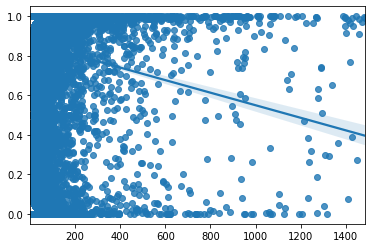

In [ ]:
import seaborn as sns
# data[data.groupby('user_id')['user_id'].transform('size')>2000]
# data["user_id"].value_counts()
x=data.groupby('user_id').size()
x=x[x<1500]
y=data.loc[data['user_id'].isin(x.index)].groupby('user_id')['is_retweet'].sum()/x
sns.regplot(x=x, y=y)
